# Simple Lyapunov function test

In [1]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import matplotlib.lines as mlines
plt.rcParams.update({'font.size': 14})

## Figure 1

In [2]:
d = 107
mu = 1e-2
L = 100
N_iterations = 400

kappa = mu/L
q = (1 - jnp.sqrt(kappa))/(1 + jnp.sqrt(kappa))

seed = 228
prng = random.PRNGKey(seed)
prng, rng = random.split(prng)
x_0 = random.normal(rng, (d,))
x_0 += 10*jnp.ones_like(x_0)
prng, rng = random.split(prng)
x_opt = random.normal(rng, (d,))

prng, rng = random.split(prng)
W_factor = random.normal(rng, (d,d))
Q,R = jnp.linalg.qr(W_factor)
Lam = jnp.diag(jnp.linspace(mu, L, d, endpoint=True))
W = Q @ Lam @ Q.T
b = W@x_opt 

def f(x, W=W, b=b):
    return 0.5*x.T @ W @ x - b.T @ x

f_opt = f(x_opt)

🤖 Working with HB
Distinct Real Eigenvalues: []
🤖 The number of complex eigenvalues: 214; The number of real eigenvalues: 4; The number of unique eigenvalues: 214
🤖 Spectrum [ 9.7995609e-01+0.j          9.8043984e-01+0.j
  9.4320941e-01+0.26672864j  9.4320941e-01-0.26672864j
  9.0622073e-01+0.3735666j   9.0622073e-01-0.3735666j
  8.6923206e-01+0.453016j    8.6923206e-01-0.453016j
  8.3224356e-01+0.5178404j   8.3224356e-01-0.5178404j
  7.9525495e-01+0.57302505j  7.9525495e-01-0.57302505j
  7.5826639e-01+0.6211443j   7.5826639e-01-0.6211443j
  7.2127777e-01+0.6637368j   7.2127777e-01-0.6637368j
  6.8428910e-01+0.7018094j   6.8428910e-01-0.7018094j
  6.4730048e-01+0.73606396j  6.4730048e-01-0.73606396j
  6.1031193e-01+0.767012j    6.1031193e-01-0.767012j
  5.7332325e-01+0.7950398j   5.7332325e-01-0.7950398j
  5.3633475e-01+0.820447j    5.3633475e-01-0.820447j
  4.9934614e-01+0.84347j     4.9934614e-01-0.84347j
  4.6235749e-01+0.8642995j   4.6235749e-01-0.8642995j
  4.2536896e-01+0.8830908

/var/folders/7m/3rbdnx5n5sz625f3l87m91cc0000gn/T/ipykernel_51914/2601939272.py:181: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


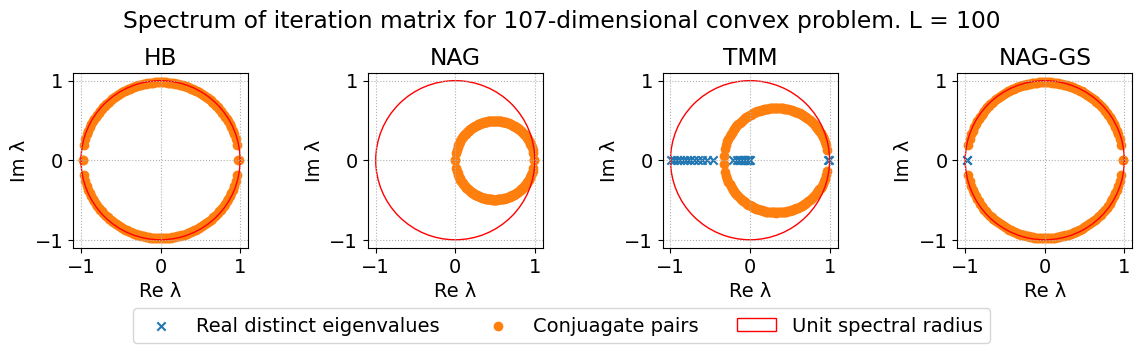

In [3]:
plt.rcParams.update({'font.size': 14})
methods = ["HB", "NAG", "TMM", "NAG-GS"]
# Set up the figure and axis
fig, axs = plt.subplots(1, len(methods), figsize=(3*len(methods), 3.5), subplot_kw=dict(box_aspect=1), layout="constrained")
distances_to_optimum = {method: [] for method in methods}
f_s = {method: [] for method in methods}
grad_norms = {method: [] for method in methods}
lyapunovs = {method: [] for method in methods}
lyapunovs_components = {method: dict(zip(range(d), [[] for d in range(d)])) for method in methods}
add_labels = {method: "" for method in methods}
for i_method, method in enumerate(methods):
    print("================")
    print(f"🤖 Working with {method}")
    x_curr = x_0
    x_hat_curr = Q.T@(x_0 - x_opt)
    x_prev = x_0
    x_hat_prev = Q.T@(x_0 - x_opt)
    x_prev_prev = x_0
    x_hat_prev_prev = Q.T@(x_0 - x_opt)
    vnaggs_curr = x_0
    y = x_0
    z = jnp.vstack([x_hat_curr, x_hat_prev])

    if method == "GD":
        alpha = 1/L
        A = -alpha*Lam
        B = jnp.zeros_like(Lam)
    elif method == "HB":
        alpha = 4/(jnp.sqrt(L) + jnp.sqrt(mu))**2
        beta = ((jnp.sqrt(L) - jnp.sqrt(mu))/(jnp.sqrt(L) + jnp.sqrt(mu)))**2
        # alpha = 1e-1
        # beta = 0.95
        A = -alpha*Lam + (1+beta)*jnp.eye(d)
        B = -beta*jnp.eye(d)
        rho = jnp.sqrt(beta)
        add_labels[method] = f"α {alpha:.2f}, β {beta:.2f}"
    elif method == "NAG":
        alpha = 1/L
        beta = (jnp.sqrt(L) - jnp.sqrt(mu))/(jnp.sqrt(L) + jnp.sqrt(mu))
        # alpha = 1e-1
        # beta = 0.95
        A = (1 + beta)*(jnp.eye(d)-alpha*Lam)
        B = -beta*(jnp.eye(d)-alpha*Lam)
        rho = jnp.sqrt((1-alpha*mu)*beta)
        add_labels[method] = f"α {alpha:.2f}, β {beta:.2f}"
    elif method == "NAG-GS":
        alpha = (2 + 2*jnp.sqrt(L/mu))/(L + mu + 2*jnp.sqrt(mu*L))
        beta = (L - mu)/(L + mu + 2*jnp.sqrt(mu*L) )
        # alpha = 2e-1
        # beta = 0.95
       
        A = (2*beta + (1-beta)**2)*jnp.eye(d)-alpha*(1-beta)*Lam
        B = -beta**2*jnp.eye(d)
      
        rho = beta
        add_labels[method] = f"α {alpha:.2f}, β {beta:.2f}"
    elif method == "TMM":
        rh = 1 - jnp.sqrt(mu/L)
        # print(rh)
        # print(rh**(3/2))
        alpha = (1 + rh)/L
        beta = rh**2/(2 - rh)
        gamma = rh**2/((1 + rh)*(2 - rh))
        # alpha = 1e-1
        # beta = 0.95
        # gamma = 0.95
        A = (1 + beta)*jnp.eye(d) - alpha*(1 + gamma)*Lam
        B = alpha*gamma*Lam - beta*jnp.eye(d)
        rho = jnp.sqrt(beta - alpha*gamma*mu)
        add_labels[method] = f"α {alpha:.2f}, β {beta:.2f}, γ {gamma:.2f}"
    elif method == "Bratishka":
        a = 1e-1
        b = -1e-1
        A = a*jnp.eye(d)
        B = b*jnp.eye(d)

    M = jnp.block(
            [[A, B],
            [jnp.eye(d), jnp.zeros_like(W)]]
            ) 
    eigs = jnp.linalg.eigvals(M)
    real_eigs = jnp.array([eig for eig in eigs if jnp.isreal(eig)])
    tol = 1e-3

    # Sort real eigenvalues
    sorted_real_eigs = jnp.sort(real_eigs)

    # Compute differences between adjacent sorted real eigenvalues
    diffs = jnp.diff(sorted_real_eigs)

    # Add a tolerance on both sides of each eigenvalue, and check for overlap
    lower_bounds = jnp.concatenate((jnp.array([-jnp.inf]), sorted_real_eigs[:-1] + tol))
    upper_bounds = jnp.concatenate((sorted_real_eigs[1:] - tol, jnp.array([jnp.inf])))

    # Compare each eigenvalue's lower bound with its upper bound
    is_distinct = (sorted_real_eigs - lower_bounds > tol) & (upper_bounds - sorted_real_eigs > tol)

    # Extract distinct real eigenvalues
    real_distinct = sorted_real_eigs[is_distinct]

    # Output the list of distinct real eigenvalues
    print("Distinct Real Eigenvalues:", real_distinct)
    mask = ~jnp.isin(eigs, real_distinct)
    conjugate_pairs = eigs[mask]

    # Count unique eigenvalues
    unique_eigs = len(jnp.unique(eigs))

    # Print results
    print(f"🤖 The number of complex eigenvalues: {len(conjugate_pairs)}; The number of real eigenvalues: {len(real_eigs)}; The number of unique eigenvalues: {unique_eigs}")
    print(f"🤖 Spectrum {eigs}")
    print(f"🤖 Eigenvalues absolute values {[jnp.abs(eig) for eig in eigs]}")

    # Separate scatter plots for real and complex eigenvalues
    axs[i_method].scatter(real_distinct.real, real_distinct.imag, marker='x', label=f'Distinct Real Eigenvalues')  # 'x' marker for real eigenvalues
    axs[i_method].scatter(conjugate_pairs.real, conjugate_pairs.imag, marker='o', label=f'Conjugate pairs')  # 'o' marker for complex eigenvalues

    # Set labels and title
    axs[i_method].set_xlabel('Re λ')
    axs[i_method].set_ylabel('Im λ')
    # # For the scalar case
    axs[i_method].set_title(f'{method}')
    axs[i_method].grid(linestyle=":")
    
    # Add the unit circle
    unit_circle = Circle((0, 0), 1, edgecolor='red', facecolor='none', label="Unit spectral radius")
    axs[i_method].add_patch(unit_circle)

    # If you want to set an aspect ratio, include the following line
    # axs[i_method].set_aspect('equal', adjustable='box')

    print(f"🤖 Spectral radius matrix - {max([jnp.abs(eig) for eig in eigs]):.3f}; table - {rho:.3f}")
    for iter in range(N_iterations):
        df = grad(f)
        distances_to_optimum[method].append(jnp.linalg.norm(x_curr - x_opt))
        f_s[method].append(jnp.abs(f(x_curr) - f_opt))
        grad_norms[method].append(jnp.linalg.norm(df(x_curr)))
        V = jnp.linalg.norm(x_prev - x_opt)**2 - (x_curr-x_opt).T@(x_prev_prev-x_opt)
        # V = (x_prev[-1] - x_opt[-1])**2 - (x_curr[-1]-x_opt[-1])*(x_prev_prev[-1]-x_opt[-1])
        # V = jnp.linalg.norm(x_prev - x_opt)**2 - (x_curr-x_opt).T@(x_curr-x_opt)
        for comp in range(d):
            V_ind = (x_prev[comp] - x_opt[comp])**2 - (x_curr[comp]-x_opt[comp])*(x_prev_prev[comp]-x_opt[comp])
            lyapunovs_components[method][comp].append(max(V_ind, 1e-9))
        lyapunovs[method].append(max(V, 1e-9))
        
        if method == "GD":
            x_next = x_curr - alpha*df(x_curr)
        elif method == "HB":
            x_next = x_curr - alpha*df(x_curr) + beta*(x_curr - x_prev)
        elif method == "NAG":
            y = x_curr + beta*(x_curr - x_prev)
            x_next = y - alpha*df(y)
        elif method == "NAG-GS":
            y = beta*y + (1-beta)*x_curr - alpha*df(x_curr)
            x_next = beta*x_curr + (1-beta)*y
            # a = alpha/(1+alpha)
            # x_next = (1-a)*x_curr + a*vnaggs_curr
            # vnaggs_next = (1-a)*vnaggs_curr+a*x_next - 1/mu*a*df(x_next)
            # vnaggs_curr = vnaggs_next
        elif method == "TMM":
            x_next = (1+beta)*x_curr - beta*x_prev - alpha*df((1+gamma)*x_curr - gamma*x_prev)
        # elif method == "Bratishka":
        #     x_next = a*x_curr + b*x_prev
        
        # z = M@z

        # print(z)

        x_prev_prev = x_prev
        x_prev = x_curr
        x_curr = x_next
        # print(f"🤖 z {z[0]}")
        # print(f"🤖 from z {Q@z[0] + x_opt}")
    lyapunovs[method][0] = None
    for comp in range(d):
        lyapunovs_components[method][comp][0] = None

# fig.suptitle(r"$\lambda_1^M, \lambda_2^M$")   
# fig.suptitle(f"Spectrum of iteration matrix for {d}-dimensional problem. L/μ = {L/mu:.1f}")  
fig.suptitle(f"Spectrum of iteration matrix for {d}-dimensional convex problem. L = {L:.0f}")                                                             
fig.tight_layout()

plt.subplots_adjust(top=0.8, bottom=0.3)
legend_labels = ["Real distinct eigenvalues", "Conjuagate pairs", "Unit spectral radius"]

fig.legend(legend_labels, loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=len(legend_labels))
plt.savefig(f"eigen_distr_{d}_{L}.pdf")
plt.show()

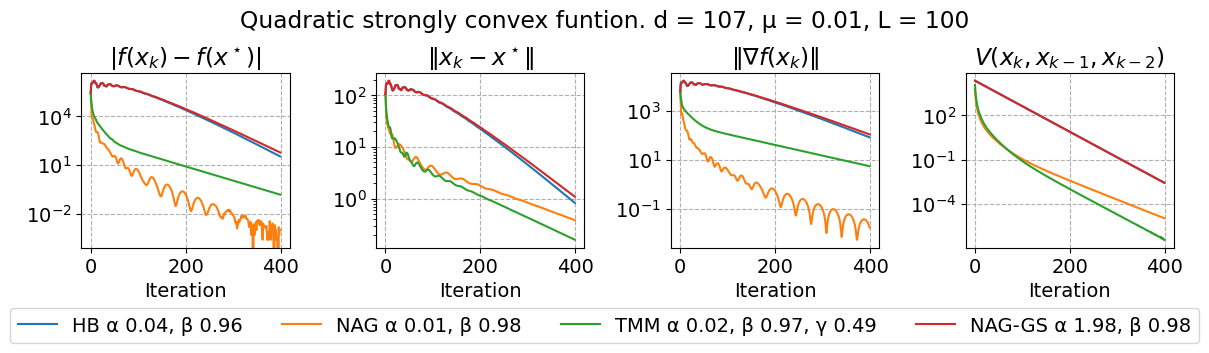

In [4]:
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 14})

fig, axs = plt.subplots(1, 4, figsize=(12, 3.5))
legend_labels = []
for method in methods:
    label = method+" " +add_labels[method]
    if label not in legend_labels:
        legend_labels.append(label)
    axs[0].semilogy(f_s[method], label=method)
    axs[0].set_title(r'$\vert f(x_k) - f(x^\star)\vert$')

    axs[1].semilogy(distances_to_optimum[method], label=method)
    axs[1].set_title(r'$\|x_k - x^\star\|$')

    axs[2].semilogy(grad_norms[method], label=method)
    axs[2].set_title(r'$\|\nabla f(x_k)\|$')

    axs[3].semilogy(lyapunovs[method], label=method)
    axs[3].set_title(r'$V(x_k, x_{k-1}, x_{k-2})$')

for ax in axs.flat:
    ax.set(xlabel='Iteration')
    ax.grid(linestyle='--')

fig.suptitle(f"Quadratic strongly convex funtion. d = {d}, μ = {mu}, L = {L:.0f}")                                                                  
fig.tight_layout()

plt.subplots_adjust(top=0.8, bottom=0.3)

fig.legend(legend_labels, loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=len(legend_labels))
plt.savefig(f"quad_simple_optimal_{d}_{L}.pdf")
plt.show()


## Figure 3

In [23]:
# Set of parameters for figure 1
d = 10
mu = 1e-1
L = 1e2
if d==1:
    L = mu
N_iterations = 320
kappa = mu/L
q = (1 - jnp.sqrt(kappa))/(1 + jnp.sqrt(kappa))

seed = 228
prng = random.PRNGKey(seed)
prng, rng = random.split(prng)
x_0 = random.normal(rng, (d,))
x_0 += 10*jnp.ones_like(x_0)
prng, rng = random.split(prng)
x_opt = random.normal(rng, (d,))

prng, rng = random.split(prng)
W_factor = random.normal(rng, (d,d))
Q,R = jnp.linalg.qr(W_factor)
Lam = jnp.diag(jnp.linspace(mu, L, d, endpoint=True))
W = Q @ Lam @ Q.T
b = W@x_opt 

def f(x, W=W, b=b):
    return 0.5*x.T @ W @ x - b.T @ x

f_opt = f(x_opt)

🤖 Working with HB
Distinct Real Eigenvalues: []
🤖 The number of complex eigenvalues: 20; The number of real eigenvalues: 2; The number of unique eigenvalues: 20
🤖 Spectrum [ 0.9386931 +1.6657553e-04j  0.9386931 -1.6657553e-04j
  0.5214962 +7.8050393e-01j  0.5214962 -7.8050393e-01j
  0.10429914+9.3288082e-01j  0.10429914-9.3288082e-01j
 -0.31289777+8.8500834e-01j -0.31289777-8.8500834e-01j
 -0.7300947 +5.9000552e-01j -0.7300947 -5.9000552e-01j
  0.73009455+5.9000564e-01j  0.73009455-5.9000564e-01j
  0.31289768+8.8500834e-01j  0.31289768-8.8500834e-01j
 -0.10429931+9.3288064e-01j -0.10429931-9.3288064e-01j
 -0.5214963 +7.8050393e-01j -0.5214963 -7.8050393e-01j
 -0.93906164+0.0000000e+00j -0.9383247 +0.0000000e+00j]
🤖 Eigenvalues absolute values [Array(0.9386931, dtype=float32), Array(0.9386931, dtype=float32), Array(0.938693, dtype=float32), Array(0.938693, dtype=float32), Array(0.9386932, dtype=float32), Array(0.9386932, dtype=float32), Array(0.93869305, dtype=float32), Array(0.93869305

/var/folders/7m/3rbdnx5n5sz625f3l87m91cc0000gn/T/ipykernel_1894/2601939272.py:181: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


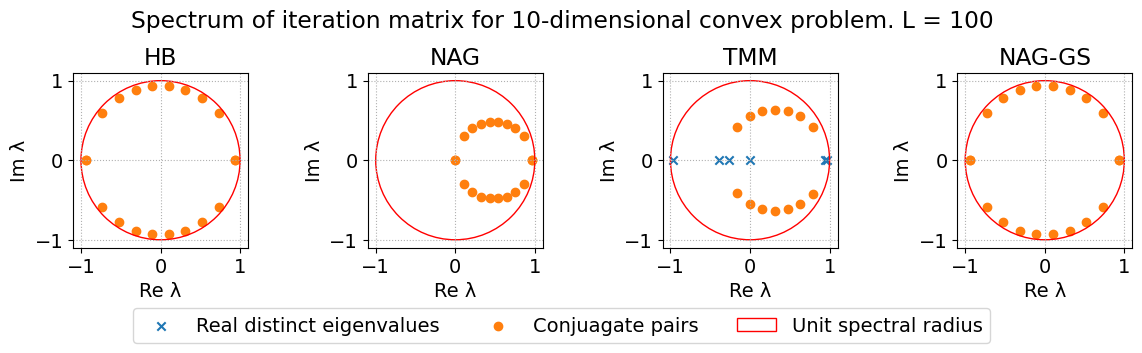

In [24]:
plt.rcParams.update({'font.size': 14})
methods = ["HB", "NAG", "TMM", "NAG-GS"]
# Set up the figure and axis
fig, axs = plt.subplots(1, len(methods), figsize=(3*len(methods), 3.5), subplot_kw=dict(box_aspect=1), layout="constrained")
distances_to_optimum = {method: [] for method in methods}
f_s = {method: [] for method in methods}
grad_norms = {method: [] for method in methods}
lyapunovs = {method: [] for method in methods}
lyapunovs_components = {method: dict(zip(range(d), [[] for d in range(d)])) for method in methods}
add_labels = {method: "" for method in methods}
for i_method, method in enumerate(methods):
    print("================")
    print(f"🤖 Working with {method}")
    x_curr = x_0
    x_hat_curr = Q.T@(x_0 - x_opt)
    x_prev = x_0
    x_hat_prev = Q.T@(x_0 - x_opt)
    x_prev_prev = x_0
    x_hat_prev_prev = Q.T@(x_0 - x_opt)
    vnaggs_curr = x_0
    y = x_0
    z = jnp.vstack([x_hat_curr, x_hat_prev])

    if method == "GD":
        alpha = 1/L
        A = -alpha*Lam
        B = jnp.zeros_like(Lam)
    elif method == "HB":
        alpha = 4/(jnp.sqrt(L) + jnp.sqrt(mu))**2
        beta = ((jnp.sqrt(L) - jnp.sqrt(mu))/(jnp.sqrt(L) + jnp.sqrt(mu)))**2
        # alpha = 1e-1
        # beta = 0.95
        A = -alpha*Lam + (1+beta)*jnp.eye(d)
        B = -beta*jnp.eye(d)
        rho = jnp.sqrt(beta)
        add_labels[method] = f"α {alpha:.2f}, β {beta:.2f}"
    elif method == "NAG":
        alpha = 1/L
        beta = (jnp.sqrt(L) - jnp.sqrt(mu))/(jnp.sqrt(L) + jnp.sqrt(mu))
        # alpha = 1e-1
        # beta = 0.95
        A = (1 + beta)*(jnp.eye(d)-alpha*Lam)
        B = -beta*(jnp.eye(d)-alpha*Lam)
        rho = jnp.sqrt((1-alpha*mu)*beta)
        add_labels[method] = f"α {alpha:.2f}, β {beta:.2f}"
    elif method == "NAG-GS":
        alpha = (2 + 2*jnp.sqrt(L/mu))/(L + mu + 2*jnp.sqrt(mu*L))
        beta = (L - mu)/(L + mu + 2*jnp.sqrt(mu*L) )
        # alpha = 2e-1
        # beta = 0.95
       
        A = (2*beta + (1-beta)**2)*jnp.eye(d)-alpha*(1-beta)*Lam
        B = -beta**2*jnp.eye(d)
      
        rho = beta
        add_labels[method] = f"α {alpha:.2f}, β {beta:.2f}"
    elif method == "TMM":
        rh = 1 - jnp.sqrt(mu/L)
        # print(rh)
        # print(rh**(3/2))
        alpha = (1 + rh)/L
        beta = rh**2/(2 - rh)
        gamma = rh**2/((1 + rh)*(2 - rh))
        # alpha = 1e-1
        # beta = 0.95
        # gamma = 0.95
        A = (1 + beta)*jnp.eye(d) - alpha*(1 + gamma)*Lam
        B = alpha*gamma*Lam - beta*jnp.eye(d)
        rho = jnp.sqrt(beta - alpha*gamma*mu)
        add_labels[method] = f"α {alpha:.2f}, β {beta:.2f}, γ {gamma:.2f}"
    elif method == "Bratishka":
        a = 1e-1
        b = -1e-1
        A = a*jnp.eye(d)
        B = b*jnp.eye(d)

    M = jnp.block(
            [[A, B],
            [jnp.eye(d), jnp.zeros_like(W)]]
            ) 
    eigs = jnp.linalg.eigvals(M)
    real_eigs = jnp.array([eig for eig in eigs if jnp.isreal(eig)])
    tol = 1e-3

    # Sort real eigenvalues
    sorted_real_eigs = jnp.sort(real_eigs)

    # Compute differences between adjacent sorted real eigenvalues
    diffs = jnp.diff(sorted_real_eigs)

    # Add a tolerance on both sides of each eigenvalue, and check for overlap
    lower_bounds = jnp.concatenate((jnp.array([-jnp.inf]), sorted_real_eigs[:-1] + tol))
    upper_bounds = jnp.concatenate((sorted_real_eigs[1:] - tol, jnp.array([jnp.inf])))

    # Compare each eigenvalue's lower bound with its upper bound
    is_distinct = (sorted_real_eigs - lower_bounds > tol) & (upper_bounds - sorted_real_eigs > tol)

    # Extract distinct real eigenvalues
    real_distinct = sorted_real_eigs[is_distinct]

    # Output the list of distinct real eigenvalues
    print("Distinct Real Eigenvalues:", real_distinct)
    mask = ~jnp.isin(eigs, real_distinct)
    conjugate_pairs = eigs[mask]

    # Count unique eigenvalues
    unique_eigs = len(jnp.unique(eigs))

    # Print results
    print(f"🤖 The number of complex eigenvalues: {len(conjugate_pairs)}; The number of real eigenvalues: {len(real_eigs)}; The number of unique eigenvalues: {unique_eigs}")
    print(f"🤖 Spectrum {eigs}")
    print(f"🤖 Eigenvalues absolute values {[jnp.abs(eig) for eig in eigs]}")

    # Separate scatter plots for real and complex eigenvalues
    axs[i_method].scatter(real_distinct.real, real_distinct.imag, marker='x', label=f'Distinct Real Eigenvalues')  # 'x' marker for real eigenvalues
    axs[i_method].scatter(conjugate_pairs.real, conjugate_pairs.imag, marker='o', label=f'Conjugate pairs')  # 'o' marker for complex eigenvalues

    # Set labels and title
    axs[i_method].set_xlabel('Re λ')
    axs[i_method].set_ylabel('Im λ')
    # # For the scalar case
    axs[i_method].set_title(f'{method}')
    axs[i_method].grid(linestyle=":")
    
    # Add the unit circle
    unit_circle = Circle((0, 0), 1, edgecolor='red', facecolor='none', label="Unit spectral radius")
    axs[i_method].add_patch(unit_circle)

    # If you want to set an aspect ratio, include the following line
    # axs[i_method].set_aspect('equal', adjustable='box')

    print(f"🤖 Spectral radius matrix - {max([jnp.abs(eig) for eig in eigs]):.3f}; table - {rho:.3f}")
    for iter in range(N_iterations):
        df = grad(f)
        distances_to_optimum[method].append(jnp.linalg.norm(x_curr - x_opt))
        f_s[method].append(jnp.abs(f(x_curr) - f_opt))
        grad_norms[method].append(jnp.linalg.norm(df(x_curr)))
        V = jnp.linalg.norm(x_prev - x_opt)**2 - (x_curr-x_opt).T@(x_prev_prev-x_opt)
        # V = (x_prev[-1] - x_opt[-1])**2 - (x_curr[-1]-x_opt[-1])*(x_prev_prev[-1]-x_opt[-1])
        # V = jnp.linalg.norm(x_prev - x_opt)**2 - (x_curr-x_opt).T@(x_curr-x_opt)
        for comp in range(d):
            V_ind = (x_prev[comp] - x_opt[comp])**2 - (x_curr[comp]-x_opt[comp])*(x_prev_prev[comp]-x_opt[comp])
            lyapunovs_components[method][comp].append(max(V_ind, 1e-9))
        lyapunovs[method].append(max(V, 1e-9))
        
        if method == "GD":
            x_next = x_curr - alpha*df(x_curr)
        elif method == "HB":
            x_next = x_curr - alpha*df(x_curr) + beta*(x_curr - x_prev)
        elif method == "NAG":
            y = x_curr + beta*(x_curr - x_prev)
            x_next = y - alpha*df(y)
        elif method == "NAG-GS":
            y = beta*y + (1-beta)*x_curr - alpha*df(x_curr)
            x_next = beta*x_curr + (1-beta)*y
            # a = alpha/(1+alpha)
            # x_next = (1-a)*x_curr + a*vnaggs_curr
            # vnaggs_next = (1-a)*vnaggs_curr+a*x_next - 1/mu*a*df(x_next)
            # vnaggs_curr = vnaggs_next
        elif method == "TMM":
            x_next = (1+beta)*x_curr - beta*x_prev - alpha*df((1+gamma)*x_curr - gamma*x_prev)
        # elif method == "Bratishka":
        #     x_next = a*x_curr + b*x_prev
        
        # z = M@z

        # print(z)

        x_prev_prev = x_prev
        x_prev = x_curr
        x_curr = x_next
        # print(f"🤖 z {z[0]}")
        # print(f"🤖 from z {Q@z[0] + x_opt}")
    lyapunovs[method][0] = None
    for comp in range(d):
        lyapunovs_components[method][comp][0] = None

# fig.suptitle(r"$\lambda_1^M, \lambda_2^M$")   
# fig.suptitle(f"Spectrum of iteration matrix for {d}-dimensional problem. L/μ = {L/mu:.1f}")  
fig.suptitle(f"Spectrum of iteration matrix for {d}-dimensional convex problem. L = {L:.0f}")                                                             
fig.tight_layout()

plt.subplots_adjust(top=0.8, bottom=0.3)
legend_labels = ["Real distinct eigenvalues", "Conjuagate pairs", "Unit spectral radius"]

fig.legend(legend_labels, loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=len(legend_labels))
plt.savefig(f"eigen_distr_{d}_{L}.pdf")
plt.show()

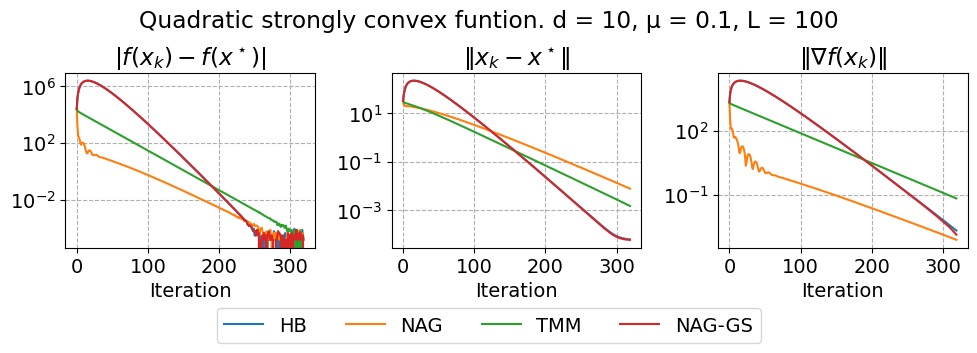

In [25]:
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 14})

fig, axs = plt.subplots(1, 3, figsize=(10, 3.5))
legend_labels = []
for method in methods:
    label = method
    if label not in legend_labels:
        legend_labels.append(label)
    axs[0].semilogy(f_s[method], label=method)
    axs[0].set_title(r'$\vert f(x_k) - f(x^\star)\vert$')

    axs[1].semilogy(distances_to_optimum[method], label=method)
    axs[1].set_title(r'$\|x_k - x^\star\|$')

    axs[2].semilogy(grad_norms[method], label=method)
    axs[2].set_title(r'$\|\nabla f(x_k)\|$')

    # axs[3].semilogy(lyapunovs[method], label=method)
    # axs[3].set_title(r'$V(x_k, x_{k-1}, x_{k-2})$')

for ax in axs.flat:
    ax.set(xlabel='Iteration')
    ax.grid(linestyle='--')

fig.suptitle(f"Quadratic strongly convex funtion. d = {d}, μ = {mu}, L = {L:.0f}")                                                                  
fig.tight_layout()

plt.subplots_adjust(top=0.8, bottom=0.3)

fig.legend(legend_labels, loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=len(legend_labels))
plt.savefig(f"quad_simple_optimal_{d}_{L}.pdf")
plt.show()


## Figure 4

In [26]:
# Set of parameters for figure 4
d = 10
mu = 1
L = 20
N_iterations = 50

kappa = mu/L
q = (1 - jnp.sqrt(kappa))/(1 + jnp.sqrt(kappa))

seed = 228
prng = random.PRNGKey(seed)
prng, rng = random.split(prng)
x_0 = random.normal(rng, (d,))
x_0 += 10*jnp.ones_like(x_0)
prng, rng = random.split(prng)
x_opt = random.normal(rng, (d,))

prng, rng = random.split(prng)
W_factor = random.normal(rng, (d,d))
Q,R = jnp.linalg.qr(W_factor)
Lam = jnp.diag(jnp.linspace(mu, L, d, endpoint=True))
W = Q @ Lam @ Q.T
b = W@x_opt 

def f(x, W=W, b=b):
    return 0.5*x.T @ W @ x - b.T @ x

f_opt = f(x_opt)

🤖 Working with HB
Distinct Real Eigenvalues: []
🤖 The number of complex eigenvalues: 20; The number of real eigenvalues: 2; The number of unique eigenvalues: 20
🤖 Spectrum [ 0.634615  +0.0000000e+00j  0.6344091 +0.0000000e+00j
  0.3525067 +5.2758366e-01j  0.3525067 -5.2758366e-01j
  0.07050133+6.3058305e-01j  0.07050133-6.3058305e-01j
 -0.211504  +5.9822363e-01j -0.211504  -5.9822363e-01j
 -0.4935093 +3.9881578e-01j -0.4935093 -3.9881578e-01j
  0.49350932+3.9881569e-01j  0.49350932-3.9881569e-01j
  0.21150401+5.9822363e-01j  0.21150401-5.9822363e-01j
 -0.07050133+6.3058305e-01j -0.07050133-6.3058305e-01j
 -0.35250676+5.2758366e-01j -0.35250676-5.2758366e-01j
 -0.63451195+2.5923972e-04j -0.63451195-2.5923972e-04j]
🤖 Eigenvalues absolute values [Array(0.634615, dtype=float32), Array(0.6344091, dtype=float32), Array(0.634512, dtype=float32), Array(0.634512, dtype=float32), Array(0.63451195, dtype=float32), Array(0.63451195, dtype=float32), Array(0.63451195, dtype=float32), Array(0.6345119

/var/folders/7m/3rbdnx5n5sz625f3l87m91cc0000gn/T/ipykernel_1894/2601939272.py:181: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


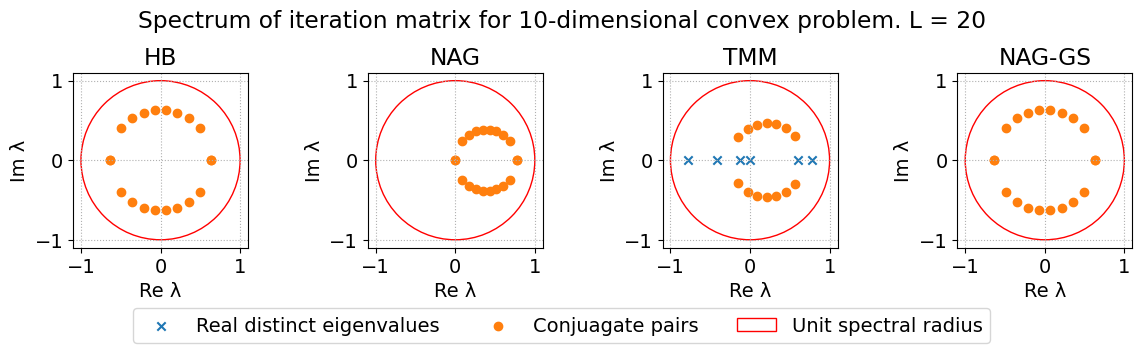

In [27]:
plt.rcParams.update({'font.size': 14})
methods = ["HB", "NAG", "TMM", "NAG-GS"]
# Set up the figure and axis
fig, axs = plt.subplots(1, len(methods), figsize=(3*len(methods), 3.5), subplot_kw=dict(box_aspect=1), layout="constrained")
distances_to_optimum = {method: [] for method in methods}
f_s = {method: [] for method in methods}
grad_norms = {method: [] for method in methods}
lyapunovs = {method: [] for method in methods}
lyapunovs_components = {method: dict(zip(range(d), [[] for d in range(d)])) for method in methods}
add_labels = {method: "" for method in methods}
for i_method, method in enumerate(methods):
    print("================")
    print(f"🤖 Working with {method}")
    x_curr = x_0
    x_hat_curr = Q.T@(x_0 - x_opt)
    x_prev = x_0
    x_hat_prev = Q.T@(x_0 - x_opt)
    x_prev_prev = x_0
    x_hat_prev_prev = Q.T@(x_0 - x_opt)
    vnaggs_curr = x_0
    y = x_0
    z = jnp.vstack([x_hat_curr, x_hat_prev])

    if method == "GD":
        alpha = 1/L
        A = -alpha*Lam
        B = jnp.zeros_like(Lam)
    elif method == "HB":
        alpha = 4/(jnp.sqrt(L) + jnp.sqrt(mu))**2
        beta = ((jnp.sqrt(L) - jnp.sqrt(mu))/(jnp.sqrt(L) + jnp.sqrt(mu)))**2
        # alpha = 1e-1
        # beta = 0.95
        A = -alpha*Lam + (1+beta)*jnp.eye(d)
        B = -beta*jnp.eye(d)
        rho = jnp.sqrt(beta)
        add_labels[method] = f"α {alpha:.2f}, β {beta:.2f}"
    elif method == "NAG":
        alpha = 1/L
        beta = (jnp.sqrt(L) - jnp.sqrt(mu))/(jnp.sqrt(L) + jnp.sqrt(mu))
        # alpha = 1e-1
        # beta = 0.95
        A = (1 + beta)*(jnp.eye(d)-alpha*Lam)
        B = -beta*(jnp.eye(d)-alpha*Lam)
        rho = jnp.sqrt((1-alpha*mu)*beta)
        add_labels[method] = f"α {alpha:.2f}, β {beta:.2f}"
    elif method == "NAG-GS":
        alpha = (2 + 2*jnp.sqrt(L/mu))/(L + mu + 2*jnp.sqrt(mu*L))
        beta = (L - mu)/(L + mu + 2*jnp.sqrt(mu*L) )
        # alpha = 2e-1
        # beta = 0.95
       
        A = (2*beta + (1-beta)**2)*jnp.eye(d)-alpha*(1-beta)*Lam
        B = -beta**2*jnp.eye(d)
      
        rho = beta
        add_labels[method] = f"α {alpha:.2f}, β {beta:.2f}"
    elif method == "TMM":
        rh = 1 - jnp.sqrt(mu/L)
        # print(rh)
        # print(rh**(3/2))
        alpha = (1 + rh)/L
        beta = rh**2/(2 - rh)
        gamma = rh**2/((1 + rh)*(2 - rh))
        # alpha = 1e-1
        # beta = 0.95
        # gamma = 0.95
        A = (1 + beta)*jnp.eye(d) - alpha*(1 + gamma)*Lam
        B = alpha*gamma*Lam - beta*jnp.eye(d)
        rho = jnp.sqrt(beta - alpha*gamma*mu)
        add_labels[method] = f"α {alpha:.2f}, β {beta:.2f}, γ {gamma:.2f}"
    elif method == "Bratishka":
        a = 1e-1
        b = -1e-1
        A = a*jnp.eye(d)
        B = b*jnp.eye(d)

    M = jnp.block(
            [[A, B],
            [jnp.eye(d), jnp.zeros_like(W)]]
            ) 
    eigs = jnp.linalg.eigvals(M)
    real_eigs = jnp.array([eig for eig in eigs if jnp.isreal(eig)])
    tol = 1e-3

    # Sort real eigenvalues
    sorted_real_eigs = jnp.sort(real_eigs)

    # Compute differences between adjacent sorted real eigenvalues
    diffs = jnp.diff(sorted_real_eigs)

    # Add a tolerance on both sides of each eigenvalue, and check for overlap
    lower_bounds = jnp.concatenate((jnp.array([-jnp.inf]), sorted_real_eigs[:-1] + tol))
    upper_bounds = jnp.concatenate((sorted_real_eigs[1:] - tol, jnp.array([jnp.inf])))

    # Compare each eigenvalue's lower bound with its upper bound
    is_distinct = (sorted_real_eigs - lower_bounds > tol) & (upper_bounds - sorted_real_eigs > tol)

    # Extract distinct real eigenvalues
    real_distinct = sorted_real_eigs[is_distinct]

    # Output the list of distinct real eigenvalues
    print("Distinct Real Eigenvalues:", real_distinct)
    mask = ~jnp.isin(eigs, real_distinct)
    conjugate_pairs = eigs[mask]

    # Count unique eigenvalues
    unique_eigs = len(jnp.unique(eigs))

    # Print results
    print(f"🤖 The number of complex eigenvalues: {len(conjugate_pairs)}; The number of real eigenvalues: {len(real_eigs)}; The number of unique eigenvalues: {unique_eigs}")
    print(f"🤖 Spectrum {eigs}")
    print(f"🤖 Eigenvalues absolute values {[jnp.abs(eig) for eig in eigs]}")

    # Separate scatter plots for real and complex eigenvalues
    axs[i_method].scatter(real_distinct.real, real_distinct.imag, marker='x', label=f'Distinct Real Eigenvalues')  # 'x' marker for real eigenvalues
    axs[i_method].scatter(conjugate_pairs.real, conjugate_pairs.imag, marker='o', label=f'Conjugate pairs')  # 'o' marker for complex eigenvalues

    # Set labels and title
    axs[i_method].set_xlabel('Re λ')
    axs[i_method].set_ylabel('Im λ')
    # # For the scalar case
    axs[i_method].set_title(f'{method}')
    axs[i_method].grid(linestyle=":")
    
    # Add the unit circle
    unit_circle = Circle((0, 0), 1, edgecolor='red', facecolor='none', label="Unit spectral radius")
    axs[i_method].add_patch(unit_circle)

    # If you want to set an aspect ratio, include the following line
    # axs[i_method].set_aspect('equal', adjustable='box')

    print(f"🤖 Spectral radius matrix - {max([jnp.abs(eig) for eig in eigs]):.3f}; table - {rho:.3f}")
    for iter in range(N_iterations):
        df = grad(f)
        distances_to_optimum[method].append(jnp.linalg.norm(x_curr - x_opt))
        f_s[method].append(jnp.abs(f(x_curr) - f_opt))
        grad_norms[method].append(jnp.linalg.norm(df(x_curr)))
        V = jnp.linalg.norm(x_prev - x_opt)**2 - (x_curr-x_opt).T@(x_prev_prev-x_opt)
        # V = (x_prev[-1] - x_opt[-1])**2 - (x_curr[-1]-x_opt[-1])*(x_prev_prev[-1]-x_opt[-1])
        # V = jnp.linalg.norm(x_prev - x_opt)**2 - (x_curr-x_opt).T@(x_curr-x_opt)
        for comp in range(d):
            V_ind = (x_prev[comp] - x_opt[comp])**2 - (x_curr[comp]-x_opt[comp])*(x_prev_prev[comp]-x_opt[comp])
            lyapunovs_components[method][comp].append(max(V_ind, 1e-9))
        lyapunovs[method].append(max(V, 1e-9))
        
        if method == "GD":
            x_next = x_curr - alpha*df(x_curr)
        elif method == "HB":
            x_next = x_curr - alpha*df(x_curr) + beta*(x_curr - x_prev)
        elif method == "NAG":
            y = x_curr + beta*(x_curr - x_prev)
            x_next = y - alpha*df(y)
        elif method == "NAG-GS":
            y = beta*y + (1-beta)*x_curr - alpha*df(x_curr)
            x_next = beta*x_curr + (1-beta)*y
            # a = alpha/(1+alpha)
            # x_next = (1-a)*x_curr + a*vnaggs_curr
            # vnaggs_next = (1-a)*vnaggs_curr+a*x_next - 1/mu*a*df(x_next)
            # vnaggs_curr = vnaggs_next
        elif method == "TMM":
            x_next = (1+beta)*x_curr - beta*x_prev - alpha*df((1+gamma)*x_curr - gamma*x_prev)
        # elif method == "Bratishka":
        #     x_next = a*x_curr + b*x_prev
        
        # z = M@z

        # print(z)

        x_prev_prev = x_prev
        x_prev = x_curr
        x_curr = x_next
        # print(f"🤖 z {z[0]}")
        # print(f"🤖 from z {Q@z[0] + x_opt}")
    lyapunovs[method][0] = None
    for comp in range(d):
        lyapunovs_components[method][comp][0] = None

# fig.suptitle(r"$\lambda_1^M, \lambda_2^M$")   
# fig.suptitle(f"Spectrum of iteration matrix for {d}-dimensional problem. L/μ = {L/mu:.1f}")  
fig.suptitle(f"Spectrum of iteration matrix for {d}-dimensional convex problem. L = {L:.0f}")                                                             
fig.tight_layout()

plt.subplots_adjust(top=0.8, bottom=0.3)
legend_labels = ["Real distinct eigenvalues", "Conjuagate pairs", "Unit spectral radius"]

fig.legend(legend_labels, loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=len(legend_labels))
plt.savefig(f"eigen_distr_{d}_{L}.pdf")
plt.show()

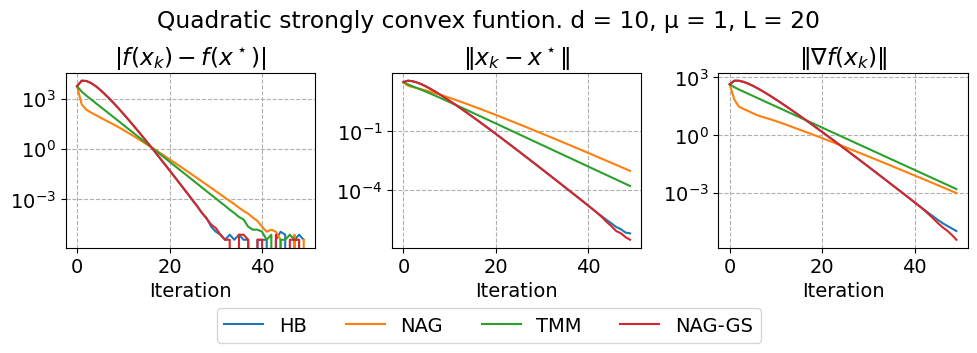

In [28]:
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 14})

fig, axs = plt.subplots(1, 3, figsize=(10, 3.5))
legend_labels = []
for method in methods:
    label = method
    if label not in legend_labels:
        legend_labels.append(label)
    axs[0].semilogy(f_s[method], label=method)
    axs[0].set_title(r'$\vert f(x_k) - f(x^\star)\vert$')

    axs[1].semilogy(distances_to_optimum[method], label=method)
    axs[1].set_title(r'$\|x_k - x^\star\|$')

    axs[2].semilogy(grad_norms[method], label=method)
    axs[2].set_title(r'$\|\nabla f(x_k)\|$')

    # axs[3].semilogy(lyapunovs[method], label=method)
    # axs[3].set_title(r'$V(x_k, x_{k-1}, x_{k-2})$')

for ax in axs.flat:
    ax.set(xlabel='Iteration')
    ax.grid(linestyle='--')

fig.suptitle(f"Quadratic strongly convex funtion. d = {d}, μ = {mu}, L = {L:.0f}")                                                                  
fig.tight_layout()

plt.subplots_adjust(top=0.8, bottom=0.3)

fig.legend(legend_labels, loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=len(legend_labels))
plt.savefig(f"quad_simple_optimal_{d}_{L}.pdf")
plt.show()


## Figure 5

In [12]:
# Set of parameters for figure 5
d = 5
mu = 1
L = 1e2
N_iterations = 220

kappa = mu/L
q = (1 - jnp.sqrt(kappa))/(1 + jnp.sqrt(kappa))

seed = 228
prng = random.PRNGKey(seed)
prng, rng = random.split(prng)
x_0 = random.normal(rng, (d,))
x_0 += 10*jnp.ones_like(x_0)
prng, rng = random.split(prng)
x_opt = random.normal(rng, (d,))

prng, rng = random.split(prng)
W_factor = random.normal(rng, (d,d))
Q,R = jnp.linalg.qr(W_factor)
Lam = jnp.diag(jnp.linspace(mu, L, d, endpoint=True))
W = Q @ Lam @ Q.T
b = W@x_opt 

def f(x, W=W, b=b):
    return 0.5*x.T @ W @ x - b.T @ x

f_opt = f(x_opt)

🤖 Working with HB
Distinct Real Eigenvalues: []
🤖 The number of complex eigenvalues: 10; The number of real eigenvalues: 0; The number of unique eigenvalues: 10
🤖 Spectrum [0.94500005+0.08351588j 0.94500005-0.08351588j 0.6975    +0.6430349j
 0.6975    -0.6430349j  0.44999996+0.8351646j  0.44999996-0.8351646j
 0.82124984+0.47491944j 0.82124984-0.47491944j 0.57375   +0.7555203j
 0.57375   -0.7555203j ]
🤖 Eigenvalues absolute values [Array(0.9486833, dtype=float32), Array(0.9486833, dtype=float32), Array(0.9486833, dtype=float32), Array(0.9486833, dtype=float32), Array(0.9486832, dtype=float32), Array(0.9486832, dtype=float32), Array(0.94868314, dtype=float32), Array(0.94868314, dtype=float32), Array(0.9486833, dtype=float32), Array(0.9486833, dtype=float32)]
🤖 Spectral radius matrix - 0.949; table - 0.949
🤖 Working with NAG
Distinct Real Eigenvalues: []
🤖 The number of complex eigenvalues: 10; The number of real eigenvalues: 2; The number of unique eigenvalues: 9
🤖 Spectrum [0.94049996+0

/var/folders/7m/3rbdnx5n5sz625f3l87m91cc0000gn/T/ipykernel_51914/3096575928.py:181: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


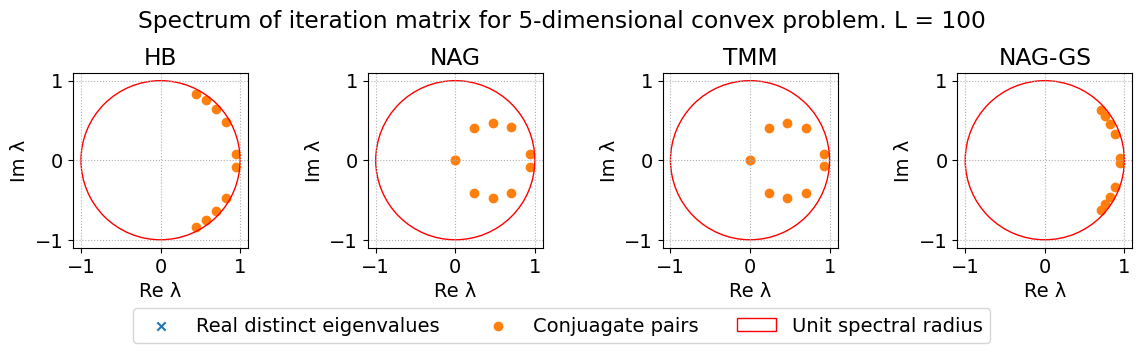

In [13]:
plt.rcParams.update({'font.size': 14})
methods = ["HB", "NAG", "TMM", "NAG-GS"]
# Set up the figure and axis
fig, axs = plt.subplots(1, len(methods), figsize=(3*len(methods), 3.5), subplot_kw=dict(box_aspect=1), layout="constrained")
distances_to_optimum = {method: [] for method in methods}
f_s = {method: [] for method in methods}
grad_norms = {method: [] for method in methods}
lyapunovs = {method: [] for method in methods}
lyapunovs_components = {method: dict(zip(range(d), [[] for d in range(d)])) for method in methods}
add_labels = {method: "" for method in methods}
for i_method, method in enumerate(methods):
    print("================")
    print(f"🤖 Working with {method}")
    x_curr = x_0
    x_hat_curr = Q.T@(x_0 - x_opt)
    x_prev = x_0
    x_hat_prev = Q.T@(x_0 - x_opt)
    x_prev_prev = x_0
    x_hat_prev_prev = Q.T@(x_0 - x_opt)
    vnaggs_curr = x_0
    y = x_0
    z = jnp.vstack([x_hat_curr, x_hat_prev])

    if method == "GD":
        alpha = 1/L
        A = -alpha*Lam
        B = jnp.zeros_like(Lam)
    elif method == "HB":
        alpha = 4/(jnp.sqrt(L) + jnp.sqrt(mu))**2
        beta = ((jnp.sqrt(L) - jnp.sqrt(mu))/(jnp.sqrt(L) + jnp.sqrt(mu)))**2
        alpha = 1e-2
        beta = 0.9
        A = -alpha*Lam + (1+beta)*jnp.eye(d)
        B = -beta*jnp.eye(d)
        rho = jnp.sqrt(beta)
        add_labels[method] = f"α {alpha:.2f}, β {beta:.2f}"
    elif method == "NAG":
        alpha = 1/L
        beta = (jnp.sqrt(L) - jnp.sqrt(mu))/(jnp.sqrt(L) + jnp.sqrt(mu))
        alpha = 1e-2
        beta = 0.9
        A = (1 + beta)*(jnp.eye(d)-alpha*Lam)
        B = -beta*(jnp.eye(d)-alpha*Lam)
        rho = jnp.sqrt((1-alpha*mu)*beta)
        add_labels[method] = f"α {alpha:.2f}, β {beta:.2f}"
    elif method == "NAG-GS":
        alpha = (2 + 2*jnp.sqrt(L/mu))/(L + mu + 2*jnp.sqrt(mu*L))
        beta = (L - mu)/(L + mu + 2*jnp.sqrt(mu*L) )
        alpha = 8e-2
        beta = 0.94
       
        A = (2*beta + (1-beta)**2)*jnp.eye(d)-alpha*(1-beta)*Lam
        B = -beta**2*jnp.eye(d)
      
        rho = beta
        add_labels[method] = f"α {alpha:.2f}, β {beta:.2f}"
    elif method == "TMM":
        rh = 1 - jnp.sqrt(mu/L)
        # print(rh)
        # print(rh**(3/2))
        alpha = (1 + rh)/L
        beta = rh**2/(2 - rh)
        gamma = rh**2/((1 + rh)*(2 - rh))
        alpha = 1e-2
        beta = 0.89
        gamma = 0.89
        A = (1 + beta)*jnp.eye(d) - alpha*(1 + gamma)*Lam
        B = alpha*gamma*Lam - beta*jnp.eye(d)
        rho = jnp.sqrt(beta - alpha*gamma*mu)
        add_labels[method] = f"α {alpha:.2f}, β {beta:.2f}, γ {gamma:.2f}"
    elif method == "Bratishka":
        a = 1e-1
        b = -1e-1
        A = a*jnp.eye(d)
        B = b*jnp.eye(d)

    M = jnp.block(
            [[A, B],
            [jnp.eye(d), jnp.zeros_like(W)]]
            ) 
    eigs = jnp.linalg.eigvals(M)
    real_eigs = jnp.array([eig for eig in eigs if jnp.isreal(eig)])
    tol = 1e-3

    # Sort real eigenvalues
    sorted_real_eigs = jnp.sort(real_eigs)

    # Compute differences between adjacent sorted real eigenvalues
    diffs = jnp.diff(sorted_real_eigs)

    # Add a tolerance on both sides of each eigenvalue, and check for overlap
    lower_bounds = jnp.concatenate((jnp.array([-jnp.inf]), sorted_real_eigs[:-1] + tol))
    upper_bounds = jnp.concatenate((sorted_real_eigs[1:] - tol, jnp.array([jnp.inf])))

    # Compare each eigenvalue's lower bound with its upper bound
    is_distinct = (sorted_real_eigs - lower_bounds > tol) & (upper_bounds - sorted_real_eigs > tol)

    # Extract distinct real eigenvalues
    real_distinct = sorted_real_eigs[is_distinct]

    # Output the list of distinct real eigenvalues
    print("Distinct Real Eigenvalues:", real_distinct)
    mask = ~jnp.isin(eigs, real_distinct)
    conjugate_pairs = eigs[mask]

    # Count unique eigenvalues
    unique_eigs = len(jnp.unique(eigs))

    # Print results
    print(f"🤖 The number of complex eigenvalues: {len(conjugate_pairs)}; The number of real eigenvalues: {len(real_eigs)}; The number of unique eigenvalues: {unique_eigs}")
    print(f"🤖 Spectrum {eigs}")
    print(f"🤖 Eigenvalues absolute values {[jnp.abs(eig) for eig in eigs]}")

    # Separate scatter plots for real and complex eigenvalues
    axs[i_method].scatter(real_distinct.real, real_distinct.imag, marker='x', label=f'Distinct Real Eigenvalues')  # 'x' marker for real eigenvalues
    axs[i_method].scatter(conjugate_pairs.real, conjugate_pairs.imag, marker='o', label=f'Conjugate pairs')  # 'o' marker for complex eigenvalues

    # Set labels and title
    axs[i_method].set_xlabel('Re λ')
    axs[i_method].set_ylabel('Im λ')
    # # For the scalar case
    axs[i_method].set_title(f'{method}')
    axs[i_method].grid(linestyle=":")
    
    # Add the unit circle
    unit_circle = Circle((0, 0), 1, edgecolor='red', facecolor='none', label="Unit spectral radius")
    axs[i_method].add_patch(unit_circle)

    # If you want to set an aspect ratio, include the following line
    # axs[i_method].set_aspect('equal', adjustable='box')

    print(f"🤖 Spectral radius matrix - {max([jnp.abs(eig) for eig in eigs]):.3f}; table - {rho:.3f}")
    for iter in range(N_iterations):
        df = grad(f)
        distances_to_optimum[method].append(jnp.linalg.norm(x_curr - x_opt))
        f_s[method].append(jnp.abs(f(x_curr) - f_opt))
        grad_norms[method].append(jnp.linalg.norm(df(x_curr)))
        V = jnp.linalg.norm(x_prev - x_opt)**2 - (x_curr-x_opt).T@(x_prev_prev-x_opt)
        # V = (x_prev[-1] - x_opt[-1])**2 - (x_curr[-1]-x_opt[-1])*(x_prev_prev[-1]-x_opt[-1])
        # V = jnp.linalg.norm(x_prev - x_opt)**2 - (x_curr-x_opt).T@(x_curr-x_opt)
        for comp in range(d):
            V_ind = (x_prev[comp] - x_opt[comp])**2 - (x_curr[comp]-x_opt[comp])*(x_prev_prev[comp]-x_opt[comp])
            lyapunovs_components[method][comp].append(max(V_ind, 1e-9))
        lyapunovs[method].append(max(V, 1e-9))
        
        if method == "GD":
            x_next = x_curr - alpha*df(x_curr)
        elif method == "HB":
            x_next = x_curr - alpha*df(x_curr) + beta*(x_curr - x_prev)
        elif method == "NAG":
            y = x_curr + beta*(x_curr - x_prev)
            x_next = y - alpha*df(y)
        elif method == "NAG-GS":
            y = beta*y + (1-beta)*x_curr - alpha*df(x_curr)
            x_next = beta*x_curr + (1-beta)*y
            # a = alpha/(1+alpha)
            # x_next = (1-a)*x_curr + a*vnaggs_curr
            # vnaggs_next = (1-a)*vnaggs_curr+a*x_next - 1/mu*a*df(x_next)
            # vnaggs_curr = vnaggs_next
        elif method == "TMM":
            x_next = (1+beta)*x_curr - beta*x_prev - alpha*df((1+gamma)*x_curr - gamma*x_prev)
        # elif method == "Bratishka":
        #     x_next = a*x_curr + b*x_prev
        
        # z = M@z

        # print(z)

        x_prev_prev = x_prev
        x_prev = x_curr
        x_curr = x_next
        # print(f"🤖 z {z[0]}")
        # print(f"🤖 from z {Q@z[0] + x_opt}")
    lyapunovs[method][0] = None
    for comp in range(d):
        lyapunovs_components[method][comp][0] = None

# fig.suptitle(r"$\lambda_1^M, \lambda_2^M$")   
# fig.suptitle(f"Spectrum of iteration matrix for {d}-dimensional problem. L/μ = {L/mu:.1f}")  
fig.suptitle(f"Spectrum of iteration matrix for {d}-dimensional convex problem. L = {L:.0f}")                                                             
fig.tight_layout()

plt.subplots_adjust(top=0.8, bottom=0.3)
legend_labels = ["Real distinct eigenvalues", "Conjuagate pairs", "Unit spectral radius"]

fig.legend(legend_labels, loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=len(legend_labels))
plt.savefig(f"eigen_distr_{d}_{L}.pdf")
plt.show()

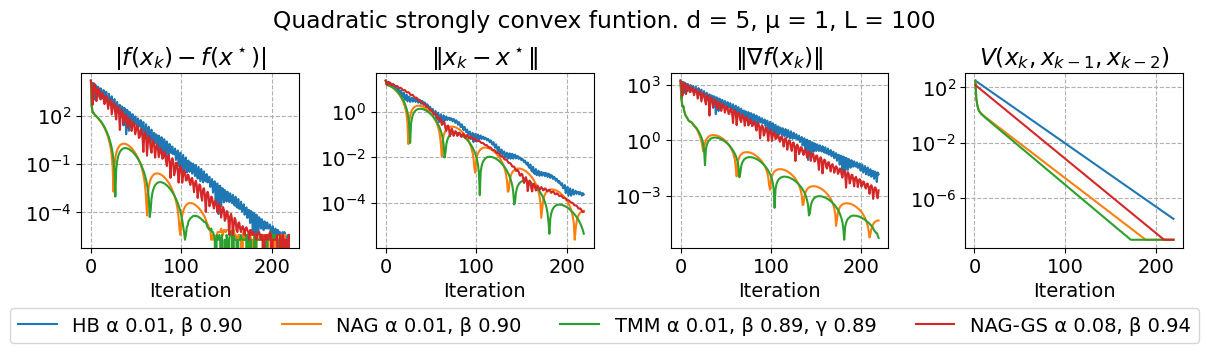

In [14]:
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 14})

fig, axs = plt.subplots(1, 4, figsize=(12, 3.5))
legend_labels = []
for method in methods:
    label = method+" " +add_labels[method]
    if label not in legend_labels:
        legend_labels.append(label)
    axs[0].semilogy(f_s[method], label=method)
    axs[0].set_title(r'$\vert f(x_k) - f(x^\star)\vert$')

    axs[1].semilogy(distances_to_optimum[method], label=method)
    axs[1].set_title(r'$\|x_k - x^\star\|$')

    axs[2].semilogy(grad_norms[method], label=method)
    axs[2].set_title(r'$\|\nabla f(x_k)\|$')

    axs[3].semilogy(lyapunovs[method], label=method)
    axs[3].set_title(r'$V(x_k, x_{k-1}, x_{k-2})$')

for ax in axs.flat:
    ax.set(xlabel='Iteration')
    ax.grid(linestyle='--')

fig.suptitle(f"Quadratic strongly convex funtion. d = {d}, μ = {mu}, L = {L:.0f}")                                                                  
fig.tight_layout()

plt.subplots_adjust(top=0.8, bottom=0.3)

fig.legend(legend_labels, loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=len(legend_labels))
plt.savefig(f"quad_simple_non_optimal_{d}_{L}.pdf")
plt.show()


## Figure 6

In [5]:
d = 5
mu = 0
L = 1
N_iterations = 300

kappa = mu/L
q = (1 - jnp.sqrt(kappa))/(1 + jnp.sqrt(kappa))

seed = 228
prng = random.PRNGKey(seed)
prng, rng = random.split(prng)
x_0 = random.normal(rng, (d,))
x_0 += 10*jnp.ones_like(x_0)
prng, rng = random.split(prng)
x_opt = random.normal(rng, (d,))

prng, rng = random.split(prng)
W_factor = random.normal(rng, (d,d))
Q,R = jnp.linalg.qr(W_factor)
Lam = jnp.diag(jnp.linspace(mu, L, d, endpoint=True))
W = Q @ Lam @ Q.T
b = W@x_opt 

def f(x, W=W, b=b):
    return 0.5*x.T @ W @ x - b.T @ x

f_opt = f(x_opt)

🤖 Working with HB
Distinct Real Eigenvalues: [0.94999886+0.j 1.0000012 +0.j]
🤖 The number of complex eigenvalues: 8; The number of real eigenvalues: 2; The number of unique eigenvalues: 10
🤖 Spectrum [1.0000012 +0.j         0.94999886+0.j         0.95000005+0.21794449j
 0.95000005-0.21794449j 0.92499995+0.30720517j 0.92499995-0.30720517j
 0.9625001 +0.15360215j 0.9625001 -0.15360215j 0.9375    +0.2666342j
 0.9375    -0.2666342j ]
🤖 Eigenvalues absolute values [Array(1.0000012, dtype=float32), Array(0.94999886, dtype=float32), Array(0.97467935, dtype=float32), Array(0.97467935, dtype=float32), Array(0.97467935, dtype=float32), Array(0.97467935, dtype=float32), Array(0.9746794, dtype=float32), Array(0.9746794, dtype=float32), Array(0.97467947, dtype=float32), Array(0.97467947, dtype=float32)]
🤖 Spectral radius matrix - 1.000; table - 0.975
🤖 Working with NAG
Distinct Real Eigenvalues: [0.94999886+0.j 1.0000012 +0.j]
🤖 The number of complex eigenvalues: 8; The number of real eigenvalues: 

/var/folders/7m/3rbdnx5n5sz625f3l87m91cc0000gn/T/ipykernel_84703/3611922482.py:181: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


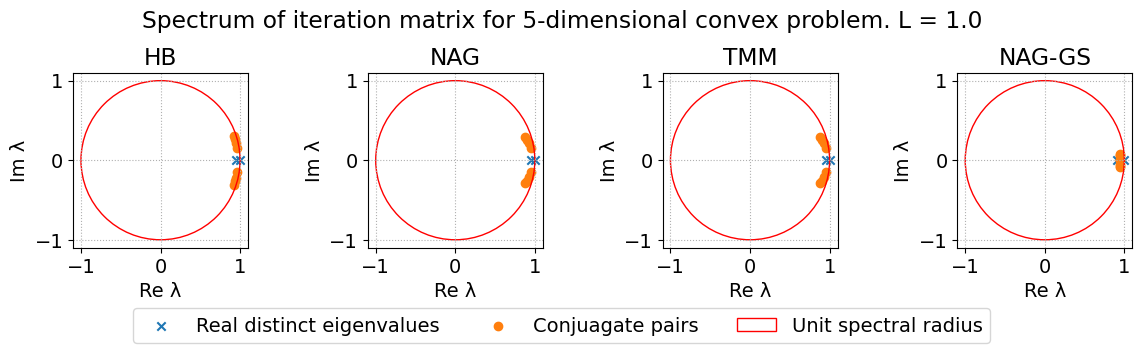

In [6]:
plt.rcParams.update({'font.size': 14})
methods = ["HB", "NAG", "TMM", "NAG-GS"]
# Set up the figure and axis
fig, axs = plt.subplots(1, len(methods), figsize=(3*len(methods), 3.5), subplot_kw=dict(box_aspect=1), layout="constrained")
distances_to_optimum = {method: [] for method in methods}
f_s = {method: [] for method in methods}
grad_norms = {method: [] for method in methods}
lyapunovs = {method: [] for method in methods}
lyapunovs_components = {method: dict(zip(range(d), [[] for d in range(d)])) for method in methods}
add_labels = {method: "" for method in methods}
for i_method, method in enumerate(methods):
    print("================")
    print(f"🤖 Working with {method}")
    x_curr = x_0
    x_hat_curr = Q.T@(x_0 - x_opt)
    x_prev = x_0
    x_hat_prev = Q.T@(x_0 - x_opt)
    x_prev_prev = x_0
    x_hat_prev_prev = Q.T@(x_0 - x_opt)
    vnaggs_curr = x_0
    y = x_0
    z = jnp.vstack([x_hat_curr, x_hat_prev])

    if method == "GD":
        alpha = 1/L
        A = -alpha*Lam
        B = jnp.zeros_like(Lam)
    elif method == "HB":
        # alpha = 4/(jnp.sqrt(L) + jnp.sqrt(mu))**2
        # beta = ((jnp.sqrt(L) - jnp.sqrt(mu))/(jnp.sqrt(L) + jnp.sqrt(mu)))**2
        alpha = 1e-1
        beta = 0.95
        A = -alpha*Lam + (1+beta)*jnp.eye(d)
        B = -beta*jnp.eye(d)
        rho = jnp.sqrt(beta)
        add_labels[method] = f"α {alpha:.2f}, β {beta:.2f}"
    elif method == "NAG":
        # alpha = 1/L
        # beta = (jnp.sqrt(L) - jnp.sqrt(mu))/(jnp.sqrt(L) + jnp.sqrt(mu))
        alpha = 1e-1
        beta = 0.95
        A = (1 + beta)*(jnp.eye(d)-alpha*Lam)
        B = -beta*(jnp.eye(d)-alpha*Lam)
        rho = jnp.sqrt((1-alpha*mu)*beta)
        add_labels[method] = f"α {alpha:.2f}, β {beta:.2f}"
    elif method == "NAG-GS":
        # alpha = (2 + 2*jnp.sqrt(L/mu))/(L + mu + 2*jnp.sqrt(mu*L))
        # beta = (L - mu)/(L + mu + 2*jnp.sqrt(mu*L) )
        alpha = 2e-1
        beta = 0.95
       
        A = (2*beta + (1-beta)**2)*jnp.eye(d)-alpha*(1-beta)*Lam
        B = -beta**2*jnp.eye(d)
      
        rho = beta
        add_labels[method] = f"α {alpha:.2f}, β {beta:.2f}"
    elif method == "TMM":
        rh = 1 - jnp.sqrt(mu/L)
        # print(rh)
        # print(rh**(3/2))
        # alpha = (1 + rh)/L
        # beta = rh**2/(2 - rh)
        # gamma = rh**2/((1 + rh)*(2 - rh))
        alpha = 1e-1
        beta = 0.95
        gamma = 0.95
        A = (1 + beta)*jnp.eye(d) - alpha*(1 + gamma)*Lam
        B = alpha*gamma*Lam - beta*jnp.eye(d)
        rho = jnp.sqrt(beta - alpha*gamma*mu)
        add_labels[method] = f"α {alpha:.2f}, β {beta:.2f}, γ {gamma:.2f}"
    elif method == "Bratishka":
        a = 1e-1
        b = -1e-1
        A = a*jnp.eye(d)
        B = b*jnp.eye(d)

    M = jnp.block(
            [[A, B],
            [jnp.eye(d), jnp.zeros_like(W)]]
            ) 
    eigs = jnp.linalg.eigvals(M)
    real_eigs = jnp.array([eig for eig in eigs if jnp.isreal(eig)])
    tol = 1e-3

    # Sort real eigenvalues
    sorted_real_eigs = jnp.sort(real_eigs)

    # Compute differences between adjacent sorted real eigenvalues
    diffs = jnp.diff(sorted_real_eigs)

    # Add a tolerance on both sides of each eigenvalue, and check for overlap
    lower_bounds = jnp.concatenate((jnp.array([-jnp.inf]), sorted_real_eigs[:-1] + tol))
    upper_bounds = jnp.concatenate((sorted_real_eigs[1:] - tol, jnp.array([jnp.inf])))

    # Compare each eigenvalue's lower bound with its upper bound
    is_distinct = (sorted_real_eigs - lower_bounds > tol) & (upper_bounds - sorted_real_eigs > tol)

    # Extract distinct real eigenvalues
    real_distinct = sorted_real_eigs[is_distinct]

    # Output the list of distinct real eigenvalues
    print("Distinct Real Eigenvalues:", real_distinct)
    mask = ~jnp.isin(eigs, real_distinct)
    conjugate_pairs = eigs[mask]

    # Count unique eigenvalues
    unique_eigs = len(jnp.unique(eigs))

    # Print results
    print(f"🤖 The number of complex eigenvalues: {len(conjugate_pairs)}; The number of real eigenvalues: {len(real_eigs)}; The number of unique eigenvalues: {unique_eigs}")
    print(f"🤖 Spectrum {eigs}")
    print(f"🤖 Eigenvalues absolute values {[jnp.abs(eig) for eig in eigs]}")

    # Separate scatter plots for real and complex eigenvalues
    axs[i_method].scatter(real_distinct.real, real_distinct.imag, marker='x', label=f'Distinct Real Eigenvalues')  # 'x' marker for real eigenvalues
    axs[i_method].scatter(conjugate_pairs.real, conjugate_pairs.imag, marker='o', label=f'Conjugate pairs')  # 'o' marker for complex eigenvalues

    # Set labels and title
    axs[i_method].set_xlabel('Re λ')
    axs[i_method].set_ylabel('Im λ')
    # # For the scalar case
    axs[i_method].set_title(f'{method}')
    axs[i_method].grid(linestyle=":")
    
    # Add the unit circle
    unit_circle = Circle((0, 0), 1, edgecolor='red', facecolor='none', label="Unit spectral radius")
    axs[i_method].add_patch(unit_circle)

    # If you want to set an aspect ratio, include the following line
    # axs[i_method].set_aspect('equal', adjustable='box')

    print(f"🤖 Spectral radius matrix - {max([jnp.abs(eig) for eig in eigs]):.3f}; table - {rho:.3f}")
    for iter in range(N_iterations):
        df = grad(f)
        distances_to_optimum[method].append(jnp.linalg.norm(x_curr - x_opt))
        f_s[method].append(jnp.abs(f(x_curr) - f_opt))
        grad_norms[method].append(jnp.linalg.norm(df(x_curr)))
        V = jnp.linalg.norm(x_prev - x_opt)**2 - (x_curr-x_opt).T@(x_prev_prev-x_opt)
        # V = (x_prev[-1] - x_opt[-1])**2 - (x_curr[-1]-x_opt[-1])*(x_prev_prev[-1]-x_opt[-1])
        # V = jnp.linalg.norm(x_prev - x_opt)**2 - (x_curr-x_opt).T@(x_curr-x_opt)
        for comp in range(d):
            V_ind = (x_prev[comp] - x_opt[comp])**2 - (x_curr[comp]-x_opt[comp])*(x_prev_prev[comp]-x_opt[comp])
            lyapunovs_components[method][comp].append(max(V_ind, 1e-9))
        lyapunovs[method].append(max(V, 1e-9))
        
        if method == "GD":
            x_next = x_curr - alpha*df(x_curr)
        elif method == "HB":
            x_next = x_curr - alpha*df(x_curr) + beta*(x_curr - x_prev)
        elif method == "NAG":
            y = x_curr + beta*(x_curr - x_prev)
            x_next = y - alpha*df(y)
        elif method == "NAG-GS":
            y = beta*y + (1-beta)*x_curr - alpha*df(x_curr)
            x_next = beta*x_curr + (1-beta)*y
            # a = alpha/(1+alpha)
            # x_next = (1-a)*x_curr + a*vnaggs_curr
            # vnaggs_next = (1-a)*vnaggs_curr+a*x_next - 1/mu*a*df(x_next)
            # vnaggs_curr = vnaggs_next
        elif method == "TMM":
            x_next = (1+beta)*x_curr - beta*x_prev - alpha*df((1+gamma)*x_curr - gamma*x_prev)
        # elif method == "Bratishka":
        #     x_next = a*x_curr + b*x_prev
        
        # z = M@z

        # print(z)

        x_prev_prev = x_prev
        x_prev = x_curr
        x_curr = x_next
        # print(f"🤖 z {z[0]}")
        # print(f"🤖 from z {Q@z[0] + x_opt}")
    lyapunovs[method][0] = None
    for comp in range(d):
        lyapunovs_components[method][comp][0] = None

# fig.suptitle(r"$\lambda_1^M, \lambda_2^M$")   
# fig.suptitle(f"Spectrum of iteration matrix for {d}-dimensional problem. L/μ = {L/mu:.1f}")  
fig.suptitle(f"Spectrum of iteration matrix for {d}-dimensional convex problem. L = {L:.1f}")                                                             
fig.tight_layout()

plt.subplots_adjust(top=0.8, bottom=0.3)
legend_labels = ["Real distinct eigenvalues", "Conjuagate pairs", "Unit spectral radius"]

fig.legend(legend_labels, loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=len(legend_labels))
plt.savefig(f"eigen_distr_{d}_{L}.pdf")
plt.show()

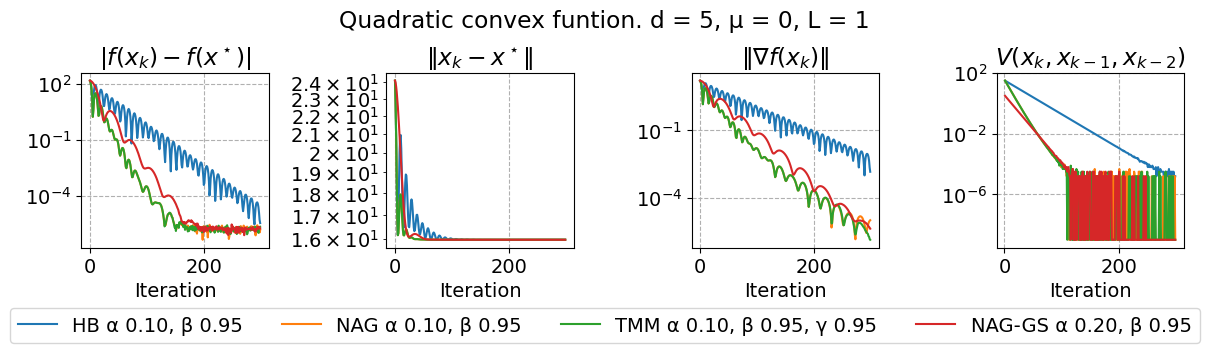

In [7]:
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 14})

fig, axs = plt.subplots(1, 4, figsize=(12, 3.5))
legend_labels = []
for method in methods:
    label = method+" " +add_labels[method]
    if label not in legend_labels:
        legend_labels.append(label)
    axs[0].semilogy(f_s[method], label=method)
    axs[0].set_title(r'$\vert f(x_k) - f(x^\star)\vert$')

    axs[1].semilogy(distances_to_optimum[method], label=method)
    axs[1].set_title(r'$\|x_k - x^\star\|$')

    axs[2].semilogy(grad_norms[method], label=method)
    axs[2].set_title(r'$\|\nabla f(x_k)\|$')

    axs[3].semilogy(lyapunovs[method], label=method)
    axs[3].set_title(r'$V(x_k, x_{k-1}, x_{k-2})$')

for ax in axs.flat:
    ax.set(xlabel='Iteration')
    ax.grid(linestyle='--')

fig.suptitle(f"Quadratic convex funtion. d = {d}, μ = {mu}, L = {L:.0f}")                                                                  
fig.tight_layout()

plt.subplots_adjust(top=0.8, bottom=0.3)

fig.legend(legend_labels, loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=len(legend_labels))
plt.savefig(f"quad_conv_optimal_{d}_{L}.pdf")
plt.show()


## Figure 7

In [20]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

d = 1
mu = 0.01
L = 3.99
N_iterations = 100

seed = 228
prng = random.PRNGKey(seed)
prng, rng = random.split(prng)
x_0 = 0.5

def f(x):
    return x**2 + 0.004975*jnp.cos(20*x)

x_opt = jnp.zeros_like(x_0)
f_opt = f(x_opt)

In [21]:
methods = ["HB", "NAG", "TMM"]
distances_to_optimum = {method: [] for method in methods}
f_s = {method: [] for method in methods}
grad_norms = {method: [] for method in methods}
lyapunovs = {method: [] for method in methods}
add_labels = {method: "" for method in methods}
for method in methods:
    print("================")
    print(f"🤖 Working with {method}")
    x_curr = x_0
    # x_hat_curr = Q.T@(x_0 - x_opt)
    x_prev = x_0
    # x_hat_prev = Q.T@(x_0 - x_opt)
    x_prev_prev = x_0
    # x_hat_prev_prev = Q.T@(x_0 - x_opt)
    vnaggs_curr = x_0
    y = x_0
    z = jnp.vstack([x_hat_curr, x_hat_prev])

    if method == "GD":
        A = -alpha*Lam
        B = jnp.zeros_like(Lam)
    elif method == "HB":
        alpha = 4/(jnp.sqrt(L) + jnp.sqrt(mu))**2
        beta = ((jnp.sqrt(L) - jnp.sqrt(mu))/(jnp.sqrt(L) + jnp.sqrt(mu)))**2
        # alpha = 1e-1
        # beta = 0.9
        A = -alpha*Lam + (1+beta)*jnp.eye(d)
        B = -beta*jnp.eye(d)
        rho = jnp.sqrt(beta)
        add_labels[method] = f"α {alpha:.2f}, β {beta:.2f}"
    elif method == "NAG":
        alpha = 1/L
        beta = (jnp.sqrt(L) - jnp.sqrt(mu))/(jnp.sqrt(L) + jnp.sqrt(mu))
        # alpha = 1e-2
        # beta = 0.9
        A = (1 + beta)*(jnp.eye(d)-alpha*Lam)
        B = -beta*(jnp.eye(d)-alpha*Lam)
        rho = jnp.sqrt((1-alpha*mu)*beta)
        add_labels[method] = f"α {alpha:.2f}, β {beta:.2f}"
    elif method == "NAG-GS":
        alpha = (2 + 2*jnp.sqrt(L/mu))/(L + mu + 2*jnp.sqrt(mu*L))
        beta = (L - mu)/(L + mu + 2*jnp.sqrt(mu*L) )
        # alpha = 7e-2
        # beta = 0.95
        A = (1 - beta)*((1 + beta)*jnp.eye(d)-alpha*Lam)
        B = -beta**2*jnp.eye(d)
        rho = beta
        add_labels[method] = f"α {alpha:.2f}, β {beta:.2f}"
    elif method == "TMM":
        rh = 1 - jnp.sqrt(mu/L)
        alpha = (1 + rh)/L
        beta = rh**2/(2 - rh)
        gamma = rh**2/((1 + rh)*(2 - rh))
        # alpha = 1e-2
        # beta = 0.9
        # gamma = 0.9
        A = (1 + beta)*jnp.eye(d) - alpha*(1 + gamma)*Lam
        B = alpha*gamma*Lam - beta*jnp.eye(d)
        rho = jnp.sqrt(beta - alpha*gamma*mu)
        add_labels[method] = f"α {alpha:.2f}, β {beta:.2f}, γ {gamma:.2f}"
    elif method == "Bratishka":
        a = 1e-1
        b = -1e-1
        A = a*jnp.eye(d)
        B = b*jnp.eye(d)

    # M = jnp.block(
    #         [[A, B],
    #         [jnp.eye(d), jnp.zeros_like(jnp.eye(d))]]
    #         ) 
    # eigs = jnp.linalg.eigvals(M)
    # print(f"🤖 Matrix M is \n{M}")
    # print(f"🤖 Spectrum {eigs}")
    # print(f"🤖 Spectral radius matrix - {max([jnp.abs(eig) for eig in eigs]):.3f}; table - {rho:.3f}")
    for iter in range(N_iterations):
        df = grad(f)
        distances_to_optimum[method].append(jnp.linalg.norm(x_curr - x_opt))
        f_s[method].append(jnp.abs(f(x_curr) - f_opt))
        grad_norms[method].append(jnp.linalg.norm(df(x_curr)))
        V = jnp.linalg.norm(x_prev - x_opt)**2 - (x_curr-x_opt)*(x_prev_prev-x_opt)
        # V = jnp.linalg.norm(x_prev - x_opt)**2 - (x_curr-x_opt).T@(x_curr-x_opt)
        lyapunovs[method].append(max(V, 1e-9))
        
        if method == "GD":
            x_next = x_curr - alpha*df(x_curr)
        elif method == "HB":
            x_next = x_curr - alpha*df(x_curr) + beta*(x_curr - x_prev)
        elif method == "NAG":
            y = x_curr + beta*(x_curr - x_prev)
            x_next = y - alpha*df(y)
        elif method == "NAG-GS":
            y = beta*y + (1-beta)*x_curr - alpha*df(x_curr)
            x_next = beta*x_curr + (1-beta)*y
            # a = alpha/(1+alpha)
            # x_next = (1-a)*x_curr + a*vnaggs_curr
            # vnaggs_next = (1-a)*vnaggs_curr+a*x_next - 1/mu*a*df(x_next)
            # vnaggs_curr = vnaggs_next
        elif method == "TMM":
            x_next = (1+beta)*x_curr - beta*x_prev - alpha*df((1+gamma)*x_curr - gamma*x_prev)
        # elif method == "Bratishka":
        #     x_next = a*x_curr + b*x_prev
        
        # z = M@z

        # print(z)

        x_prev_prev = x_prev
        x_prev = x_curr
        x_curr = x_next
        # print(f"🤖 z {z[0]}")
        # print(f"🤖 from z {Q@z[0] + x_opt}")
    lyapunovs[method][0] = None

🤖 Working with HB
🤖 Working with NAG
🤖 Working with TMM


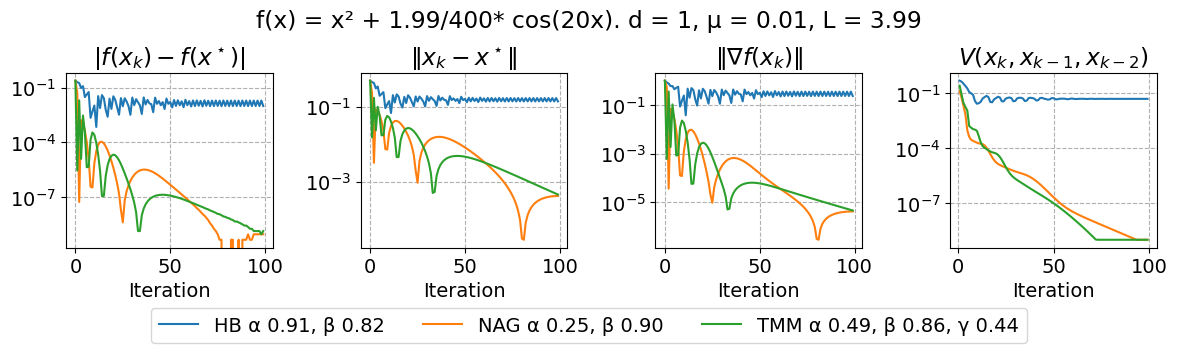

In [22]:
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 14})

fig, axs = plt.subplots(1, 4, figsize=(12, 3.5))
legend_labels = []
for method in methods:
    label = method+" " +add_labels[method]
    if label not in legend_labels:
        legend_labels.append(label)
    axs[0].semilogy(f_s[method], label=method)
    axs[0].set_title(r'$\vert f(x_k) - f(x^\star)\vert$')

    axs[1].semilogy(distances_to_optimum[method], label=method)
    axs[1].set_title(r'$\|x_k - x^\star\|$')

    axs[2].semilogy(grad_norms[method], label=method)
    axs[2].set_title(r'$\|\nabla f(x_k)\|$')

    axs[3].semilogy(lyapunovs[method], label=method)
    axs[3].set_title(r'$V(x_k, x_{k-1}, x_{k-2})$')

for ax in axs.flat:
    ax.set(xlabel='Iteration')
    ax.grid(linestyle='--')

fig.suptitle(f"f(x) = x² + 1.99/400* cos(20x). d = {d}, μ = {mu}, L = {L}")                                                                  
fig.tight_layout()

plt.subplots_adjust(top=0.8, bottom=0.3)

fig.legend(legend_labels, loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=len(legend_labels))
plt.savefig(f"str_conv_bad.pdf")
plt.show()


In [25]:
methods = ["HB", "NAG", "TMM"]
distances_to_optimum = {method: [] for method in methods}
f_s = {method: [] for method in methods}
grad_norms = {method: [] for method in methods}
lyapunovs = {method: [] for method in methods}
add_labels = {method: "" for method in methods}
for method in methods:
    print("================")
    print(f"🤖 Working with {method}")
    x_curr = x_0
    # x_hat_curr = Q.T@(x_0 - x_opt)
    x_prev = x_0
    # x_hat_prev = Q.T@(x_0 - x_opt)
    x_prev_prev = x_0
    # x_hat_prev_prev = Q.T@(x_0 - x_opt)
    vnaggs_curr = x_0
    y = x_0
    z = jnp.vstack([x_hat_curr, x_hat_prev])

    if method == "GD":
        A = -alpha*Lam
        B = jnp.zeros_like(Lam)
    elif method == "HB":
        # alpha = 4/(jnp.sqrt(L) + jnp.sqrt(mu))**2
        # beta = ((jnp.sqrt(L) - jnp.sqrt(mu))/(jnp.sqrt(L) + jnp.sqrt(mu)))**2
        alpha = 1e-1
        beta = 0.9
        A = -alpha*Lam + (1+beta)*jnp.eye(d)
        B = -beta*jnp.eye(d)
        rho = jnp.sqrt(beta)
        add_labels[method] = f"α {alpha:.2f}, β {beta:.2f}"
    elif method == "NAG":
        # alpha = 1/L
        # beta = (jnp.sqrt(L) - jnp.sqrt(mu))/(jnp.sqrt(L) + jnp.sqrt(mu))
        alpha = 1e-2
        beta = 0.9
        A = (1 + beta)*(jnp.eye(d)-alpha*Lam)
        B = -beta*(jnp.eye(d)-alpha*Lam)
        rho = jnp.sqrt((1-alpha*mu)*beta)
        add_labels[method] = f"α {alpha:.2f}, β {beta:.2f}"
    elif method == "NAG-GS":
        # alpha = (2 + 2*jnp.sqrt(L/mu))/(L + mu + 2*jnp.sqrt(mu*L))
        # beta = (L - mu)/(L + mu + 2*jnp.sqrt(mu*L) )
        alpha = 7e-2
        beta = 0.95
        A = (1 - beta)*((1 + beta)*jnp.eye(d)-alpha*Lam)
        B = -beta**2*jnp.eye(d)
        rho = beta
        add_labels[method] = f"α {alpha:.2f}, β {beta:.2f}"
    elif method == "TMM":
        # rh = 1 - jnp.sqrt(mu/L)
        # alpha = (1 + rh)/L
        # beta = rh**2/(2 - rh)
        # gamma = rh**2/((1 + rh)*(2 - rh))
        alpha = 1e-2
        beta = 0.9
        gamma = 0.9
        A = (1 + beta)*jnp.eye(d) - alpha*(1 + gamma)*Lam
        B = alpha*gamma*Lam - beta*jnp.eye(d)
        rho = jnp.sqrt(beta - alpha*gamma*mu)
        add_labels[method] = f"α {alpha:.2f}, β {beta:.2f}, γ {gamma:.2f}"
    elif method == "Bratishka":
        a = 1e-1
        b = -1e-1
        A = a*jnp.eye(d)
        B = b*jnp.eye(d)

    # M = jnp.block(
    #         [[A, B],
    #         [jnp.eye(d), jnp.zeros_like(jnp.eye(d))]]
    #         ) 
    # eigs = jnp.linalg.eigvals(M)
    # print(f"🤖 Matrix M is \n{M}")
    # print(f"🤖 Spectrum {eigs}")
    # print(f"🤖 Spectral radius matrix - {max([jnp.abs(eig) for eig in eigs]):.3f}; table - {rho:.3f}")
    for iter in range(N_iterations):
        df = grad(f)
        distances_to_optimum[method].append(jnp.linalg.norm(x_curr - x_opt))
        f_s[method].append(jnp.abs(f(x_curr) - f_opt))
        grad_norms[method].append(jnp.linalg.norm(df(x_curr)))
        V = jnp.linalg.norm(x_prev - x_opt)**2 - (x_curr-x_opt)*(x_prev_prev-x_opt)
        # V = jnp.linalg.norm(x_prev - x_opt)**2 - (x_curr-x_opt).T@(x_curr-x_opt)
        lyapunovs[method].append(max(V, 1e-9))
        
        if method == "GD":
            x_next = x_curr - alpha*df(x_curr)
        elif method == "HB":
            x_next = x_curr - alpha*df(x_curr) + beta*(x_curr - x_prev)
        elif method == "NAG":
            y = x_curr + beta*(x_curr - x_prev)
            x_next = y - alpha*df(y)
        elif method == "NAG-GS":
            y = beta*y + (1-beta)*x_curr - alpha*df(x_curr)
            x_next = beta*x_curr + (1-beta)*y
            # a = alpha/(1+alpha)
            # x_next = (1-a)*x_curr + a*vnaggs_curr
            # vnaggs_next = (1-a)*vnaggs_curr+a*x_next - 1/mu*a*df(x_next)
            # vnaggs_curr = vnaggs_next
        elif method == "TMM":
            x_next = (1+beta)*x_curr - beta*x_prev - alpha*df((1+gamma)*x_curr - gamma*x_prev)
        # elif method == "Bratishka":
        #     x_next = a*x_curr + b*x_prev
        
        # z = M@z

        # print(z)

        x_prev_prev = x_prev
        x_prev = x_curr
        x_curr = x_next
        # print(f"🤖 z {z[0]}")
        # print(f"🤖 from z {Q@z[0] + x_opt}")
    lyapunovs[method][0] = None

🤖 Working with HB
🤖 Working with NAG
🤖 Working with TMM


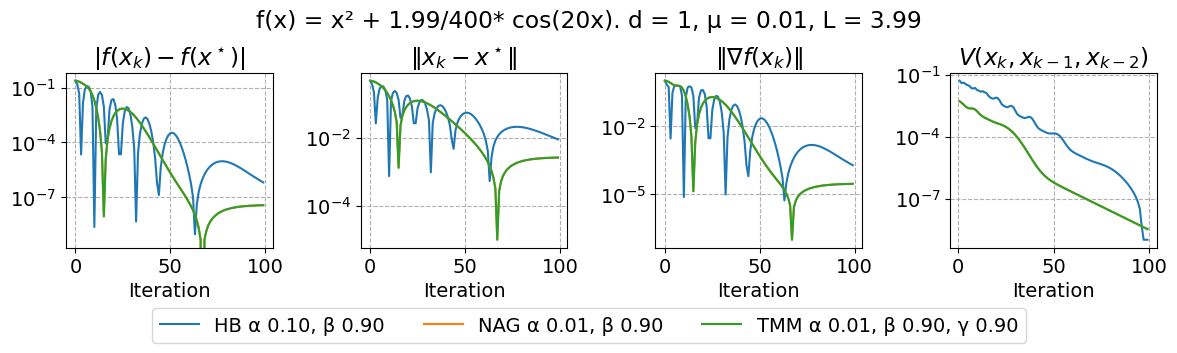

In [26]:
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 14})

fig, axs = plt.subplots(1, 4, figsize=(12, 3.5))
legend_labels = []
for method in methods:
    label = method+" " +add_labels[method]
    if label not in legend_labels:
        legend_labels.append(label)
    axs[0].semilogy(f_s[method], label=method)
    axs[0].set_title(r'$\vert f(x_k) - f(x^\star)\vert$')

    axs[1].semilogy(distances_to_optimum[method], label=method)
    axs[1].set_title(r'$\|x_k - x^\star\|$')

    axs[2].semilogy(grad_norms[method], label=method)
    axs[2].set_title(r'$\|\nabla f(x_k)\|$')

    axs[3].semilogy(lyapunovs[method], label=method)
    axs[3].set_title(r'$V(x_k, x_{k-1}, x_{k-2})$')

for ax in axs.flat:
    ax.set(xlabel='Iteration')
    ax.grid(linestyle='--')

fig.suptitle(f"f(x) = x² + 1.99/400* cos(20x). d = {d}, μ = {mu}, L = {L}")                                                                  
fig.tight_layout()

plt.subplots_adjust(top=0.8, bottom=0.3)

fig.legend(legend_labels, loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=len(legend_labels))
plt.savefig(f"str_conv_bad.pdf")
plt.show()


## Figure 8 Rosenbrock

In [27]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
from jax.scipy.special import logsumexp

d = 2
N_iterations = 500

seed = 228
prng = random.PRNGKey(seed)
prng, rng = random.split(prng)

seed = 228
prng = random.PRNGKey(seed)
prng, rng = random.split(prng)
x_0 = random.normal(rng, (d,))

def f(x):
    return jnp.exp(jnp.linalg.norm(x)**2)

x_opt = jnp.zeros_like(x_0)
f_opt = f(x_opt)

d = 2  # Number of features
m = 100  # Number of samples

# Generating random data for the example
prng = random.PRNGKey(0)
X_augmented = jnp.hstack([random.normal(prng, (m, d)), jnp.ones((m, 1))])  # Augmented with ones for bias
x_opt = jnp.array([2.0, -3.0, 0.5])
y = jnp.sign(X_augmented @ x_opt + 0.1 * random.normal(prng, (m,)))

# Make sure x_0 has the right shape:
prng, rng = random.split(prng)
x_0 = random.normal(rng, (d+1,))
x_0 += 10*jnp.ones_like(x_0)

def logistic_loss(x):
    logits = X_augmented @ x
    log_probs = logits - logsumexp(jnp.stack([jnp.zeros_like(logits), -logits], axis=-1), axis=-1)
    return -jnp.mean(y * log_probs)

f = logistic_loss
f_opt = f(x_opt)

d=2

# Rosenbrock function
def f(x):
    w1, w2 = x
    return (1 - w1)**2 + 100 * (w2 - w1**2)**2
x_0 = jnp.array([0.1, 3.0])
x_opt = jnp.array([1.0, 1.0])

In [28]:
methods = ["HB", "NAG", "TMM", "NAG-GS"]
distances_to_optimum = {method: [] for method in methods}
f_s = {method: [] for method in methods}
grad_norms = {method: [] for method in methods}
lyapunovs = {method: [] for method in methods}
add_labels = {method: "" for method in methods}
for method in methods:
    print("================")
    print(f"🤖 Working with {method}")
    x_curr = x_0
    # x_hat_curr = Q.T@(x_0 - x_opt)
    x_prev = x_0
    # x_hat_prev = Q.T@(x_0 - x_opt)
    x_prev_prev = x_0
    # x_hat_prev_prev = Q.T@(x_0 - x_opt)
    vnaggs_curr = x_0
    y = x_0
    z = jnp.vstack([x_hat_curr, x_hat_prev])

    if method == "GD":
        A = -alpha*Lam
        B = jnp.zeros_like(Lam)
    elif method == "HB":
        # alpha = 4/(jnp.sqrt(L) + jnp.sqrt(mu))**2
        # beta = ((jnp.sqrt(L) - jnp.sqrt(mu))/(jnp.sqrt(L) + jnp.sqrt(mu)))**2
        alpha = 1e-4
        beta = 0.9
        # A = -alpha*Lam + (1+beta)*jnp.eye(d)
        # B = -beta*jnp.eye(d)
        rho = jnp.sqrt(beta)
        add_labels[method] = f"α {alpha:.4f}, β {beta:.2f}"
    elif method == "NAG":
        # alpha = 1/L
        # beta = (jnp.sqrt(L) - jnp.sqrt(mu))/(jnp.sqrt(L) + jnp.sqrt(mu))
        alpha = 1e-4
        beta = 0.9
        # A = (1 + beta)*(jnp.eye(d)-alpha*Lam)
        # B = -beta*(jnp.eye(d)-alpha*Lam)
        rho = jnp.sqrt((1-alpha*mu)*beta)
        add_labels[method] = f"α {alpha:.4f}, β {beta:.2f}"
    elif method == "NAG-GS":
        # alpha = (2 + 2*jnp.sqrt(L/mu))/(L + mu + 2*jnp.sqrt(mu*L))
        # beta = (L - mu)/(L + mu + 2*jnp.sqrt(mu*L) )
        alpha = 1e-4
        beta = 0.9
        # A = (1 - beta)*((1 + beta)*jnp.eye(d)-alpha*Lam)
        # B = -beta**2*jnp.eye(d)
        rho = beta
        add_labels[method] = f"α {alpha:.4f}, β {beta:.2f}"
    elif method == "TMM":
        rh = 1 - jnp.sqrt(mu/L)
        alpha = (1 + rh)/L
        beta = rh**2/(2 - rh)
        gamma = rh**2/((1 + rh)*(2 - rh))
        alpha = 1e-4
        beta = 0.9
        gamma = 0.9
        # A = (1 + beta)*jnp.eye(d) - alpha*(1 + gamma)*Lam
        # B = alpha*gamma*Lam - beta*jnp.eye(d)
        rho = jnp.sqrt(beta - alpha*gamma*mu)
        add_labels[method] = f"α {alpha:.4f}, β {beta:.2f}, γ {gamma:.2f}"
    elif method == "Bratishka":
        a = 1e-1
        b = -1e-1
        # A = a*jnp.eye(d)
        # B = b*jnp.eye(d)

    # M = jnp.block(
    #         [[A, B],
    #         [jnp.eye(d), jnp.zeros_like(jnp.eye(d))]]
    #         ) 
    # eigs = jnp.linalg.eigvals(M)
    # print(f"🤖 Matrix M is \n{M}")
    # print(f"🤖 Spectrum {eigs}")
    # print(f"🤖 Spectral radius matrix - {max([jnp.abs(eig) for eig in eigs]):.3f}; table - {rho:.3f}")
    for iter in range(N_iterations):
        df = grad(f)
        distances_to_optimum[method].append(jnp.linalg.norm(x_curr - x_opt))
        f_s[method].append(jnp.abs(f(x_curr) - f_opt))
        grad_norms[method].append(jnp.linalg.norm(df(x_curr)))
        V = jnp.linalg.norm(x_prev - x_opt)**2 - (x_curr-x_opt).T@(x_prev_prev-x_opt)
        # V = jnp.linalg.norm(x_prev - x_opt)**2 - (x_curr-x_opt).T@(x_curr-x_opt)
        lyapunovs[method].append(max(V, 1e-9))
        
        if method == "GD":
            x_next = x_curr - alpha*df(x_curr)
        elif method == "HB":
            x_next = x_curr - alpha*df(x_curr) + beta*(x_curr - x_prev)
        elif method == "NAG":
            y = x_curr + beta*(x_curr - x_prev)
            x_next = y - alpha*df(y)
        elif method == "NAG-GS":
            y = beta*y + (1-beta)*x_curr - alpha*df(x_curr)
            x_next = beta*x_curr + (1-beta)*y
            # a = alpha/(1+alpha)
            # x_next = (1-a)*x_curr + a*vnaggs_curr
            # vnaggs_next = (1-a)*vnaggs_curr+a*x_next - 1/mu*a*df(x_next)
            # vnaggs_curr = vnaggs_next
        elif method == "TMM":
            x_next = (1+beta)*x_curr - beta*x_prev - alpha*df((1+gamma)*x_curr - gamma*x_prev)
        # elif method == "Bratishka":
        #     x_next = a*x_curr + b*x_prev
        
        # z = M@z

        # print(z)

        x_prev_prev = x_prev
        x_prev = x_curr
        x_curr = x_next
        # print(f"🤖 z {z[0]}")
        # print(f"🤖 from z {Q@z[0] + x_opt}")
    lyapunovs[method][0] = None

🤖 Working with HB
🤖 Working with NAG
🤖 Working with TMM
🤖 Working with NAG-GS


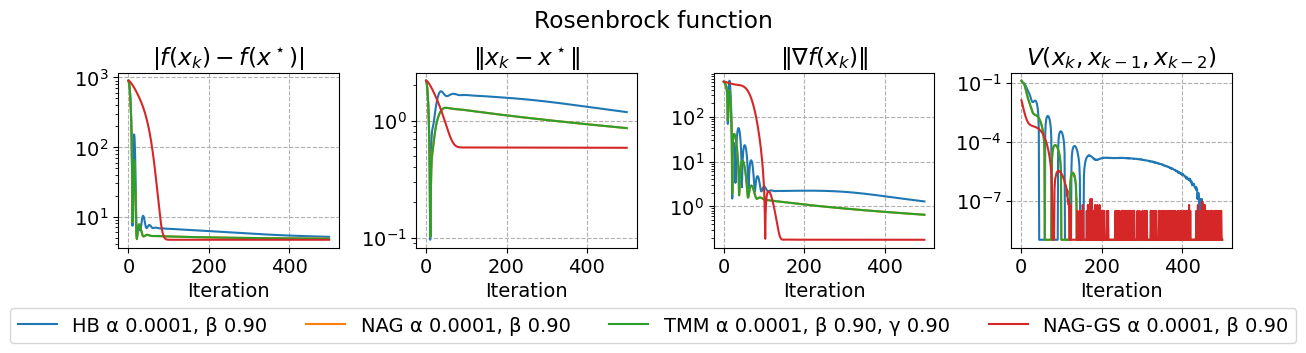

In [29]:
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 14})

fig, axs = plt.subplots(1, 4, figsize=(12, 3.5))
legend_labels = []
for method in methods:
    label = method+" " +add_labels[method]
    if label not in legend_labels:
        legend_labels.append(label)
    axs[0].semilogy(f_s[method], label=method)
    axs[0].set_title(r'$\vert f(x_k) - f(x^\star)\vert$')

    axs[1].semilogy(distances_to_optimum[method], label=method)
    axs[1].set_title(r'$\|x_k - x^\star\|$')

    axs[2].semilogy(grad_norms[method], label=method)
    axs[2].set_title(r'$\|\nabla f(x_k)\|$')

    axs[3].semilogy(lyapunovs[method], label=method)
    axs[3].set_title(r'$V(x_k, x_{k-1}, x_{k-2})$')

for ax in axs.flat:
    ax.set(xlabel='Iteration')
    ax.grid(linestyle='--')

fig.suptitle(f"Rosenbrock function")                                                                  
fig.tight_layout()

plt.subplots_adjust(top=0.8, bottom=0.3)

fig.legend(legend_labels, loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=len(legend_labels))
plt.savefig(f"non_conv.pdf")
plt.show()